In [1]:
%matplotlib inline
%pylab inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import xarray as xr
import copy
import csv
from collections import OrderedDict

from dask.distributed import Client
import climtas.nci

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib
Available exptdata keys:  ['1deg_c1', '025deg_c1', '01deg_c1', '1deg_c2', '025deg_c2', '01deg_c2', '1deg_c3', '025deg_c3', '01deg_c3']


In [2]:
import climtas.nci
climtas.nci.GadiClient(malloc_trim_threshold='64kib')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42991/status,
Dashboard: /proxy/42991/status,Workers: 8
Total threads: 8,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43219,Workers: 8
Dashboard: /proxy/42991/status,Total threads: 8
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:34643,Total threads: 1
Dashboard: /proxy/44245/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41671,


In [3]:
session = cc.database.create_session()

In [4]:
data = copy.deepcopy(exptdata.exptdict) 

In [5]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

# Parameters


In [6]:
rho=1025 # kg/m^3
omega=7.292e-5 # rad/s

maxlat_Aus= math.radians(3.5)
minlat_Aus= math.radians(-45)
maxlat_NZ= math.radians(-33)
minlat_NZ= math.radians(-49)


ff1=2*omega*math.sin(maxlat_Aus)
ff2=2*omega*math.sin(minlat_Aus)
ff3=2*omega*math.sin(maxlat_NZ)
ff4=2*omega*math.sin(minlat_NZ)

# Useful functions

In [7]:
def wcoast(island):
    ''' return boolean array that is 1 only on island's west coast '''
    islandwcoast = xr.full_like(island, False)
    islandwcoast[:,0:-2] = ((~island[:,0:-2].data) & (island[:,1:-1].data))
    return islandwcoast

In [8]:
def findcoast(row):
    ''' return index of first 1 value, or nan if none found '''
    try:
        return row.index(1) 
    except ValueError:
        return np.nan

In [9]:
def coasti(wcoast):
    ''' return i index of westernmost 1 at each latitude '''
    js = list(range(wcoast.data.shape[0]))
    return [ findcoast(x) for x in [ list(wcoast.isel(yu_ocean=j).data) for j in js ] ]

In [10]:
def Island_Rule(dxu,dyu,tau_x,tau_y):
    SAmerwcoast = wcoast(SAmer).load()
    EBi = coasti(SAmerwcoast)
    EB = [ -1e10 if np.isnan(i) else lons[i].item() for i in EBi ]
    EB = np.array(EB).reshape((-1, 1))

    # SAmerwcoast.plot(figsize=(25,8))
    
    IRpsi=zeros(len(islands))
    for kk, island in enumerate(islands):
        islandwcoast = wcoast(island).load()
        WBi = coasti(islandwcoast)
        WB = [ 1e10 if np.isnan(i) else lons[i].item() for i in WBi ]
        WB = np.array(WB).reshape((-1, 1))

        lWB = np.tile(WB, len(lons))
        lEB = np.tile(EB, len(lons))
        llons = np.tile(lons.data, (len(lats),1))

        irregion=(llons>=lWB) & (llons<=lEB)
        IRregion = xr.full_like(islandwcoast, False)
        IRregion[:] = irregion
        IRregion = IRregion.astype(bool)
        IRpathintegrand = xr.full_like(island, 0.0) #island.where(False,0)

        # meridional

        IRcoast = xr.full_like(island, False) #copy.deepcopy(island)
        IRcoast[:,0:-2] = ((~IRregion[:,0:-2].data) & (IRregion[:,1:-1].data))
        pathlength = -dyu*IRcoast
        IRpathintegrand += pathlength*tau_y

        IRcoast[:]= False
        IRcoast[:,0:-2] = ((IRregion[:,0:-2].data) & (~IRregion[:,1:-1].data))
        pathlength = dyu.where(IRcoast, other=0.0)
        IRpathintegrand += pathlength*tau_y

        # zonal
        IRcoast[:]= False
        IRcoast[0:-2,:] = ((~IRregion[0:-2,:].data) & (IRregion[1:-1,:].data))
        pathlength = dxu.where(IRcoast, other=0.0)
        IRpathintegrand += pathlength*tau_x

        IRcoast[:]= False
        IRcoast[0:-2,:] = ((IRregion[0:-2,:].data) & (~IRregion[1:-1,:].data))
        pathlength = -dxu.where(IRcoast, other=0.0)
        IRpathintegrand += pathlength*tau_x

        # sum
        tmp=sum(IRpathintegrand,0)
        

        # psi of Island Rule
        if kk == 0:
            IRpsi[kk] = -sum(tmp,0) / (ff3 - ff4)
        else:
            IRpsi[kk] = (-sum(tmp,0) -IRpsi[0]*(ff2 - ff4)) / (ff1-ff2)

#         plt.figure()
#         islandwcoast.plot(figsize=(25,8))

#         plt.figure()
#         IRregion.plot(figsize=(25,8))
        

#         plt.figure()
#         pathlength.plot(figsize=(25,8))

#         plt.figure()
#         IRpathintegrand.plot(figsize=(25,8))
        

    Trans = IRpsi/rho/1e6
    difference = Trans[1]-Trans[0]
    
    
    # return -difference    # IR value of Aus-NZ
    

    return Trans[0],Trans[1]    # IR value of Aus and IR value of NZ

# Island Rule

## every 1 years

1deg_c1
1958-01-01 00:00:00-1959-01-01 00:00:00
025deg_c1
1958-01-01 00:00:00-1959-01-01 00:00:00
01deg_c1
1958-01-01 00:00:00-1959-01-01 00:00:00
1deg_c2
1958-01-01 00:00:00-1959-01-01 00:00:00
025deg_c2
1958-01-01 00:00:00-1959-01-01 00:00:00
01deg_c2
1958-01-01 00:00:00-1959-01-01 00:00:00
1deg_c3
1958-01-01 00:00:00-1959-01-01 00:00:00
025deg_c3
1958-01-01 00:00:00-1959-01-01 00:00:00
01deg_c3
1958-01-01 00:00:00-1959-01-01 00:00:00
CPU times: user 8min 44s, sys: 17.2 s, total: 9min 1s
Wall time: 10min 1s


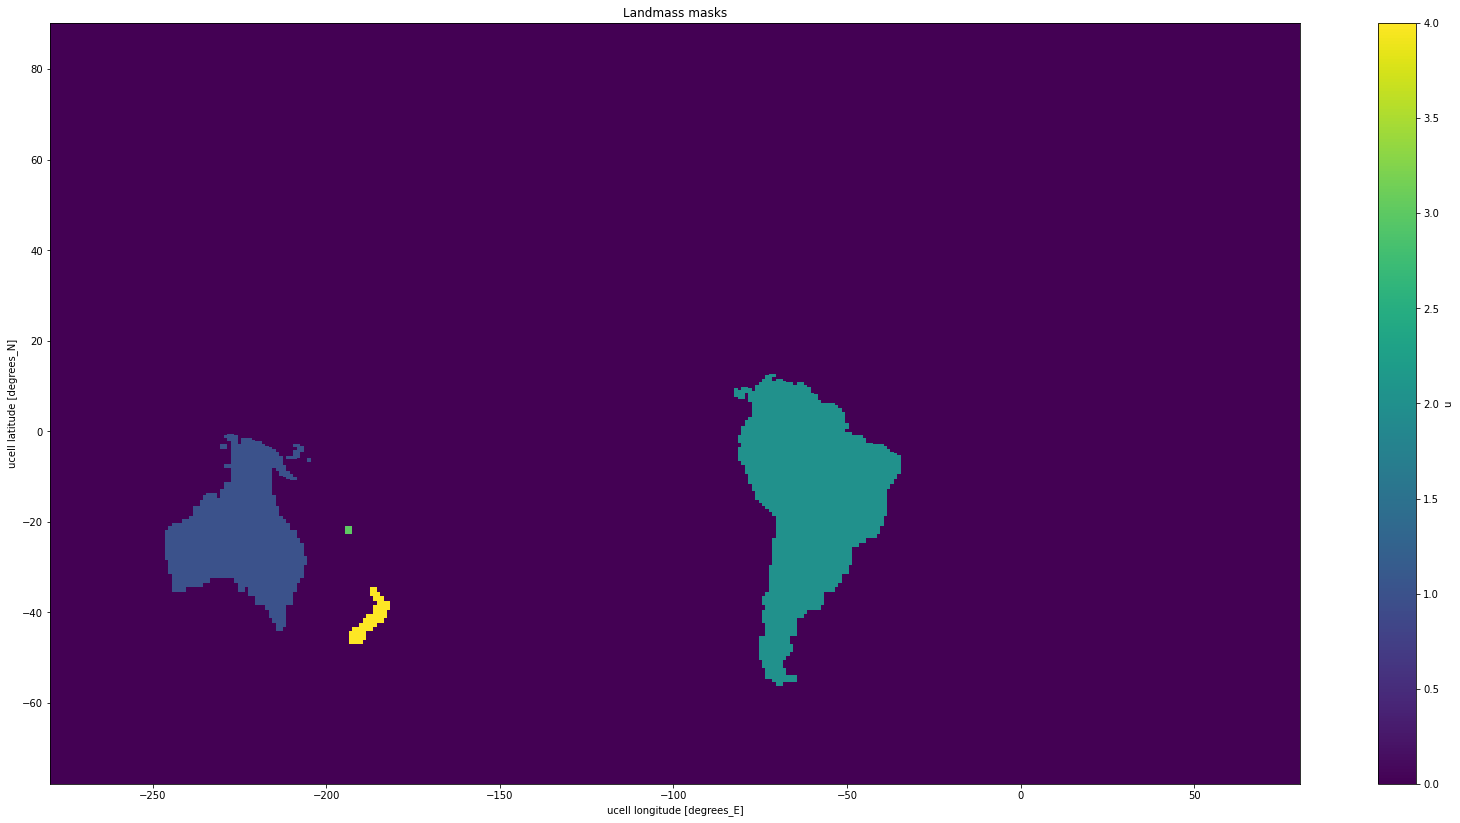

<Figure size 432x288 with 0 Axes>

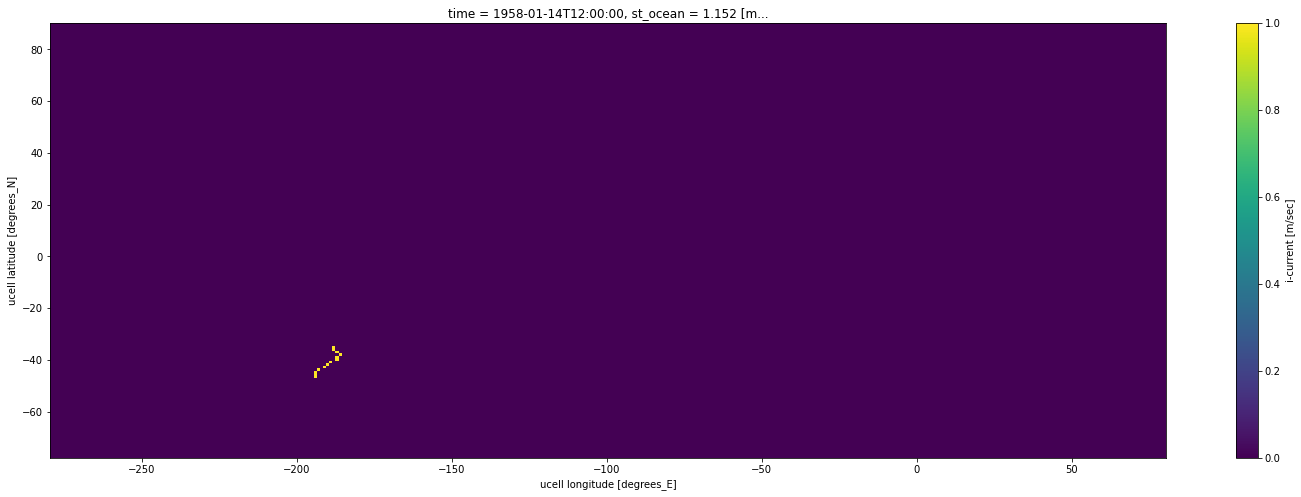

<Figure size 432x288 with 0 Axes>

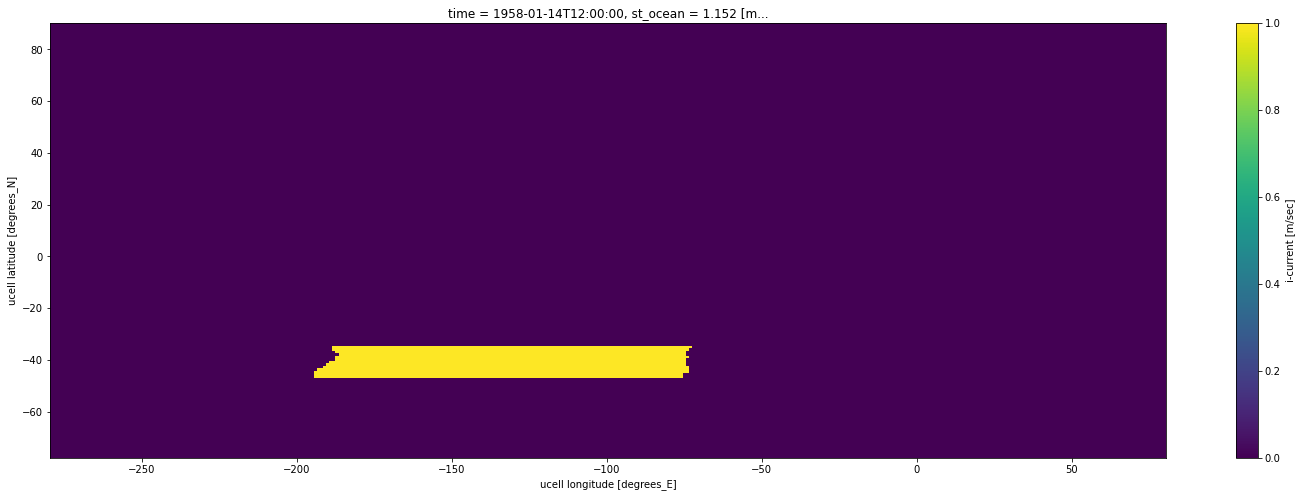

<Figure size 432x288 with 0 Axes>

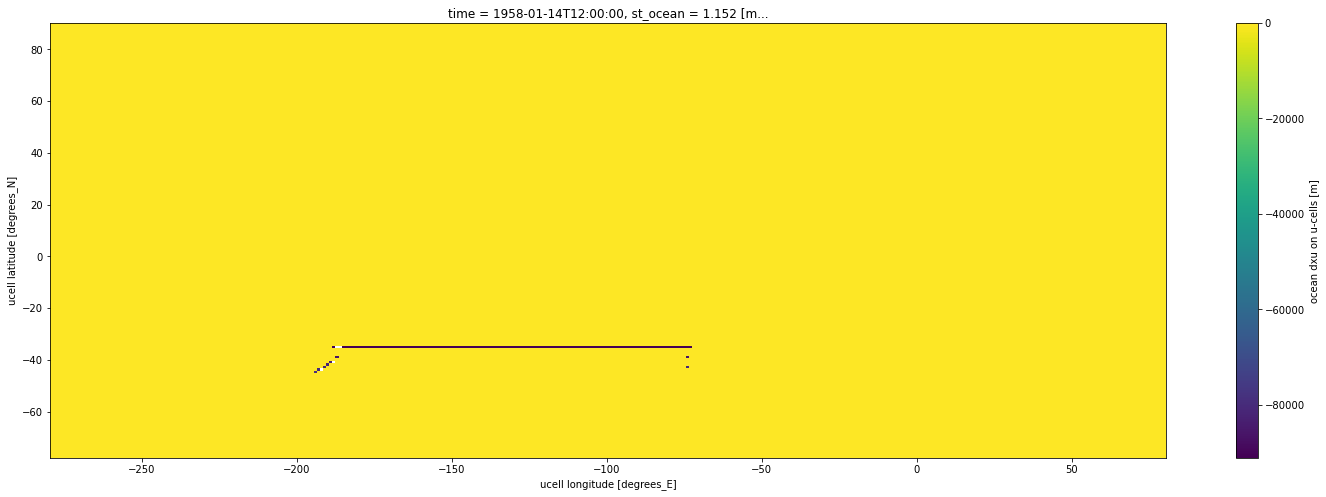

<Figure size 432x288 with 0 Axes>

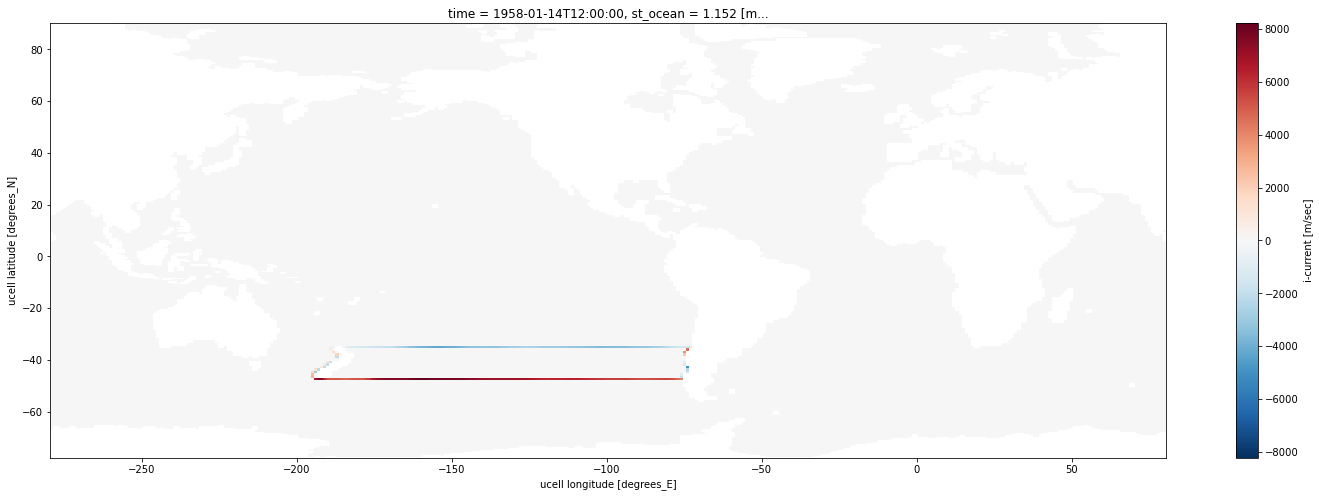

<Figure size 432x288 with 0 Axes>

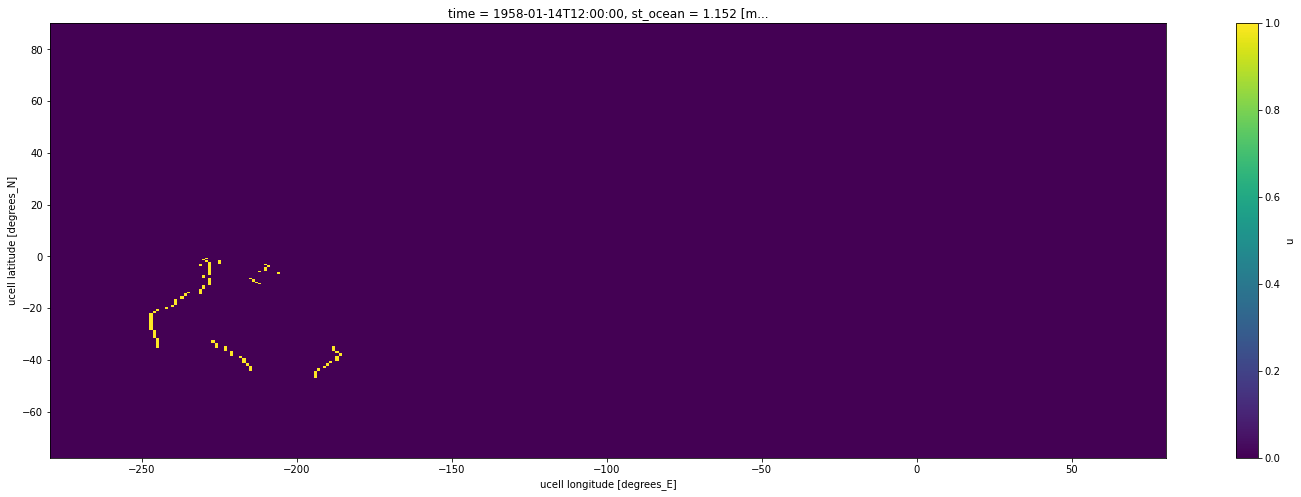

<Figure size 432x288 with 0 Axes>

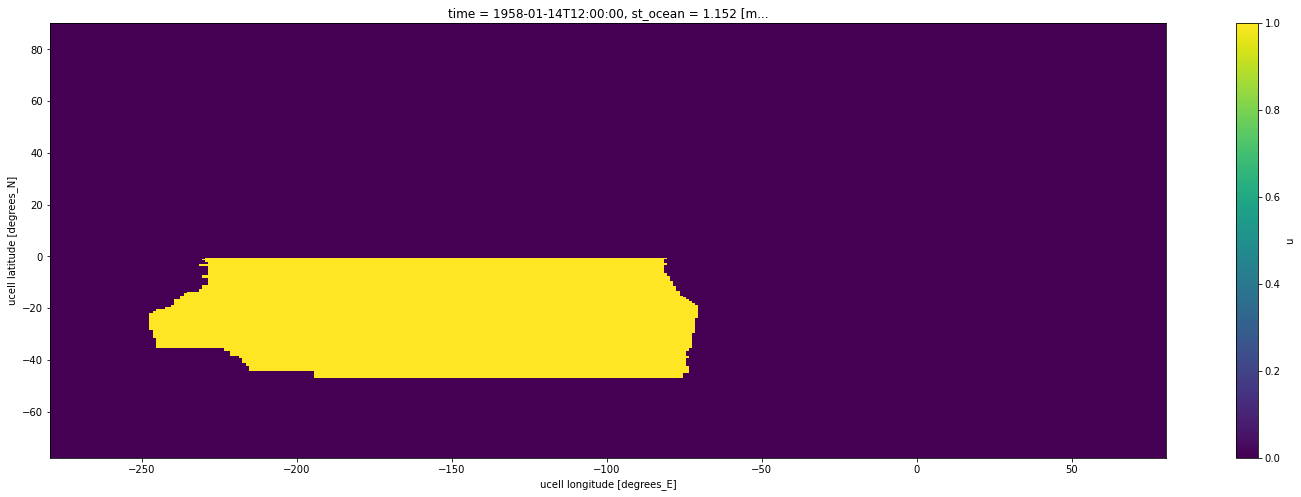

<Figure size 432x288 with 0 Axes>

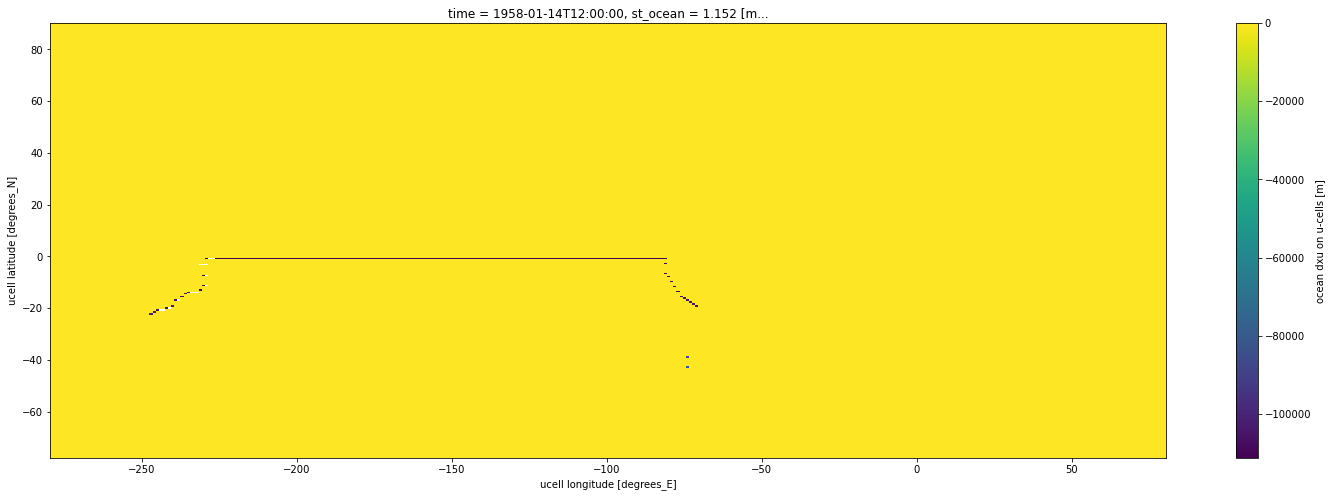

<Figure size 432x288 with 0 Axes>

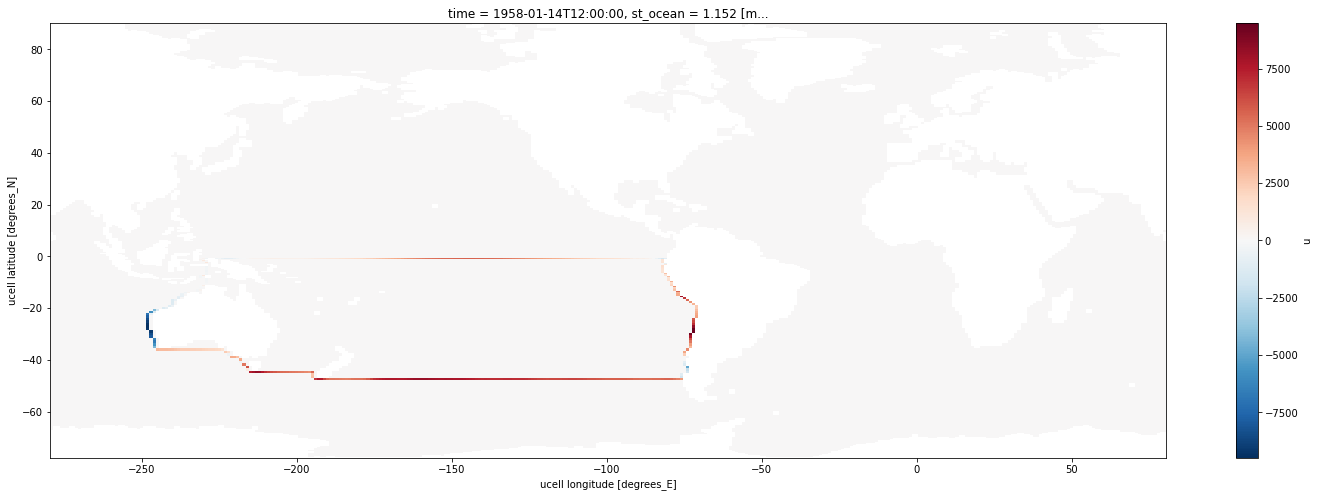

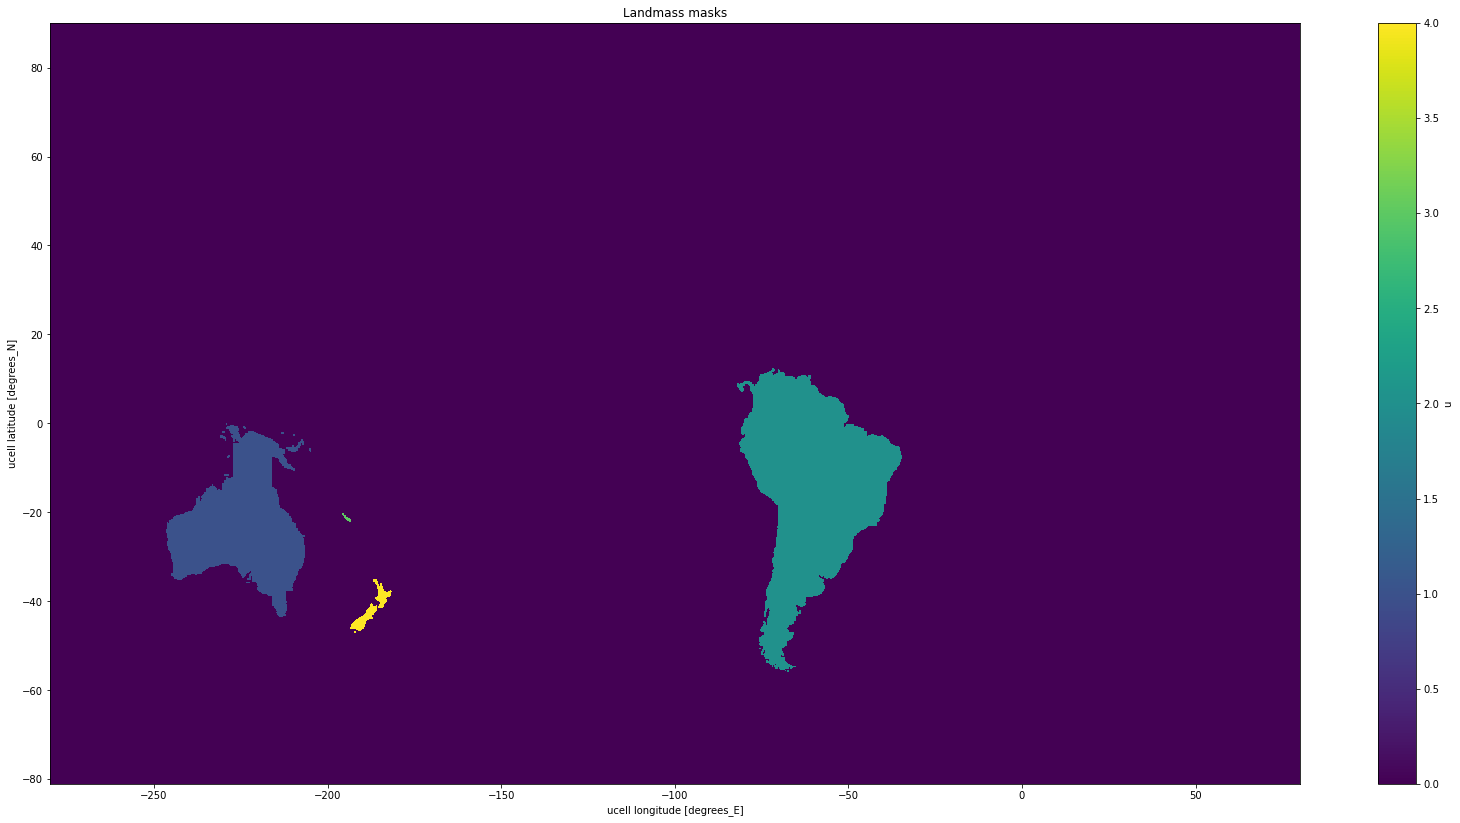

<Figure size 432x288 with 0 Axes>

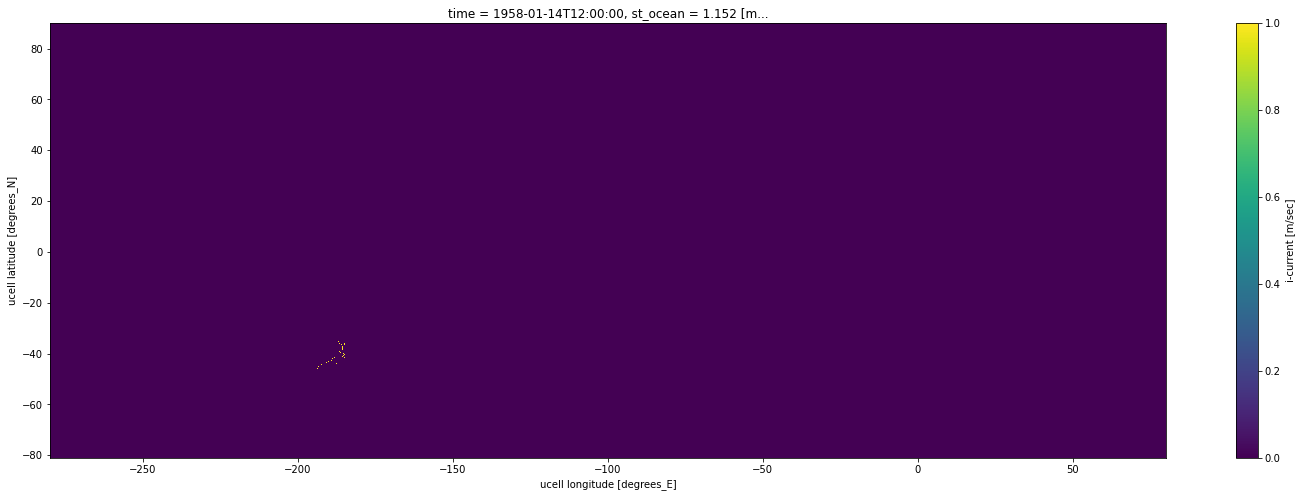

<Figure size 432x288 with 0 Axes>

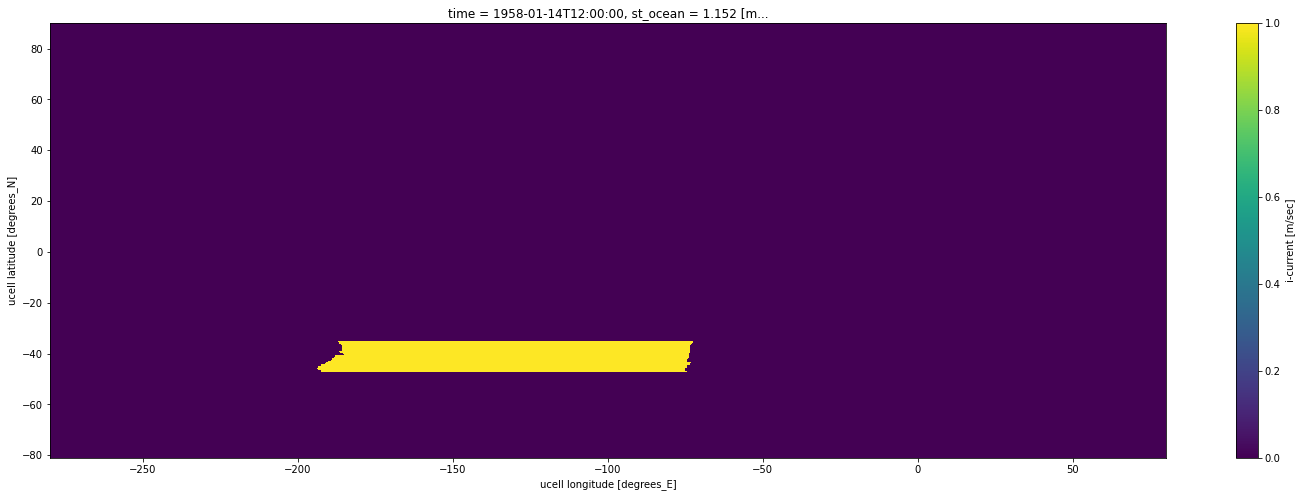

<Figure size 432x288 with 0 Axes>

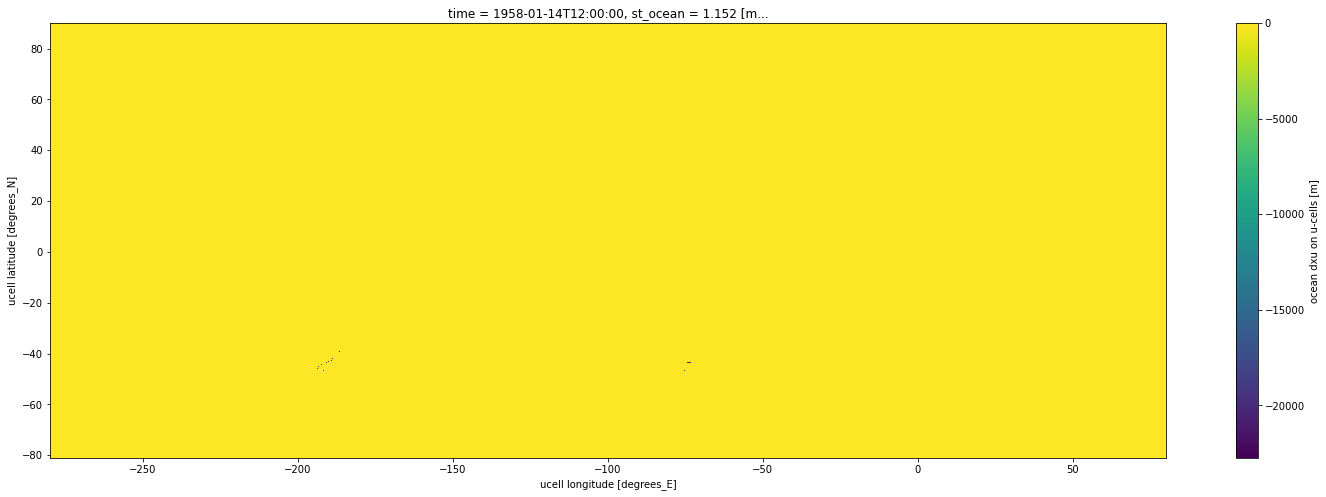

<Figure size 432x288 with 0 Axes>

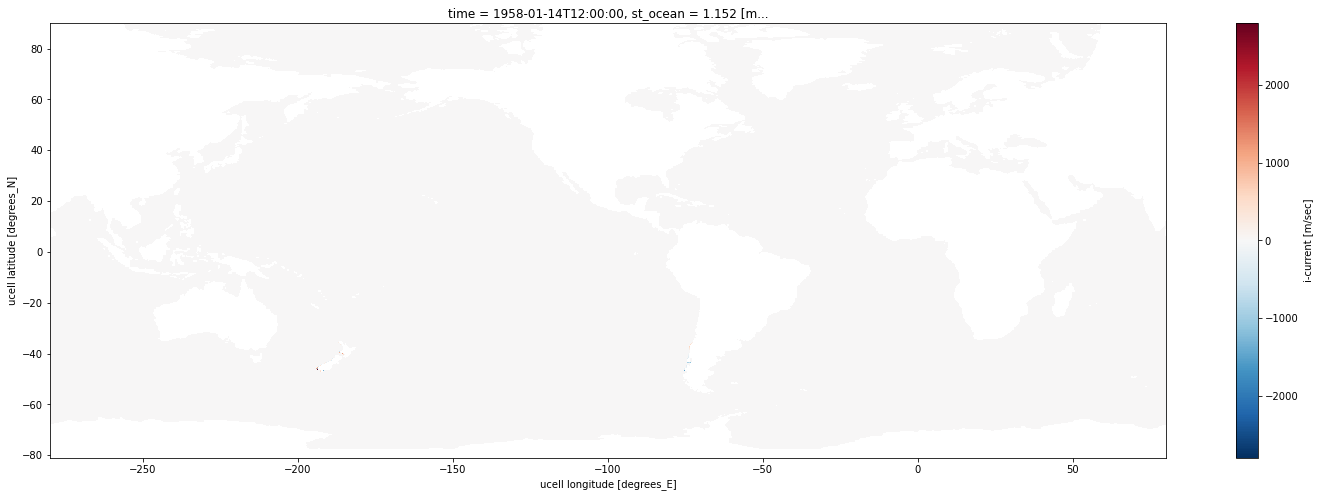

<Figure size 432x288 with 0 Axes>

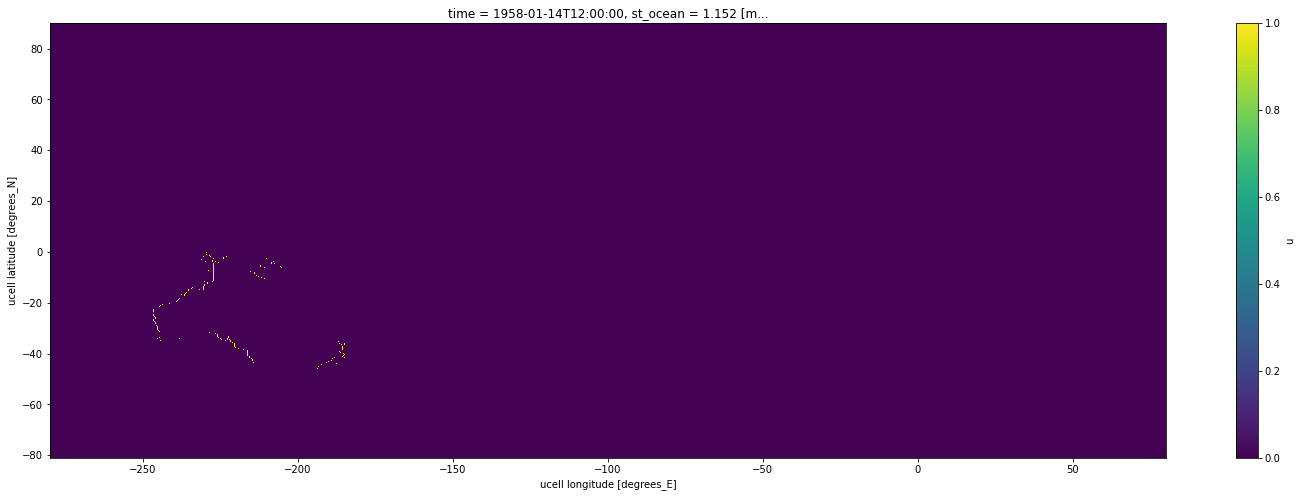

<Figure size 432x288 with 0 Axes>

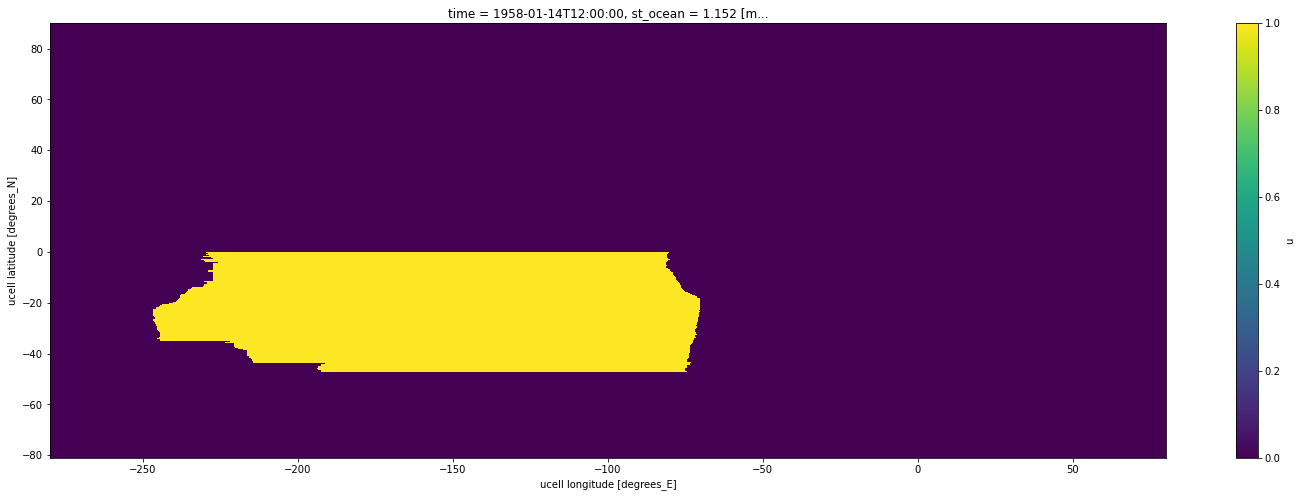

<Figure size 432x288 with 0 Axes>

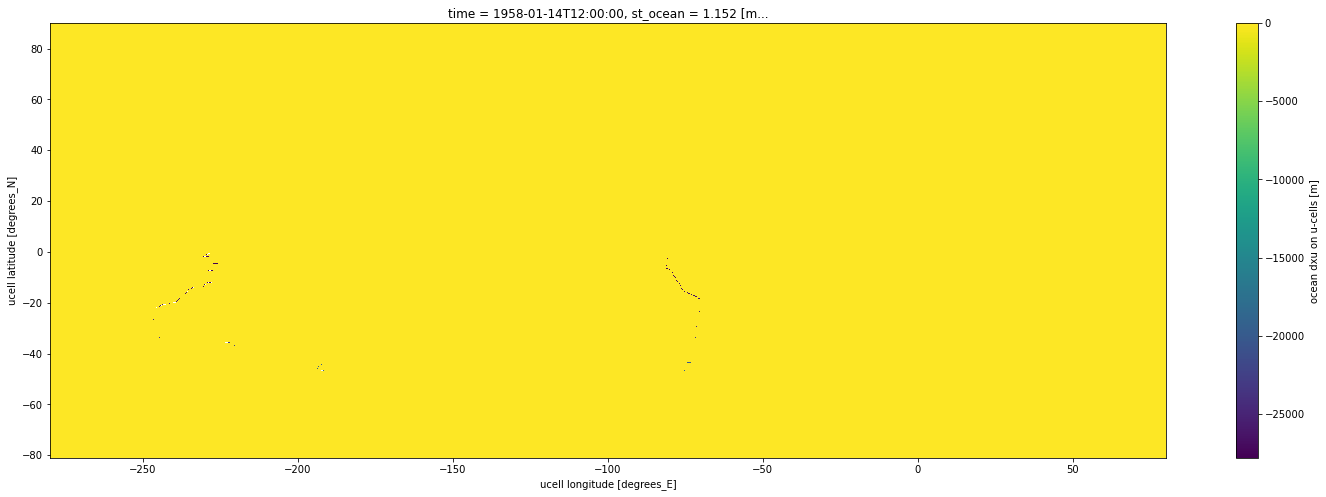

<Figure size 432x288 with 0 Axes>

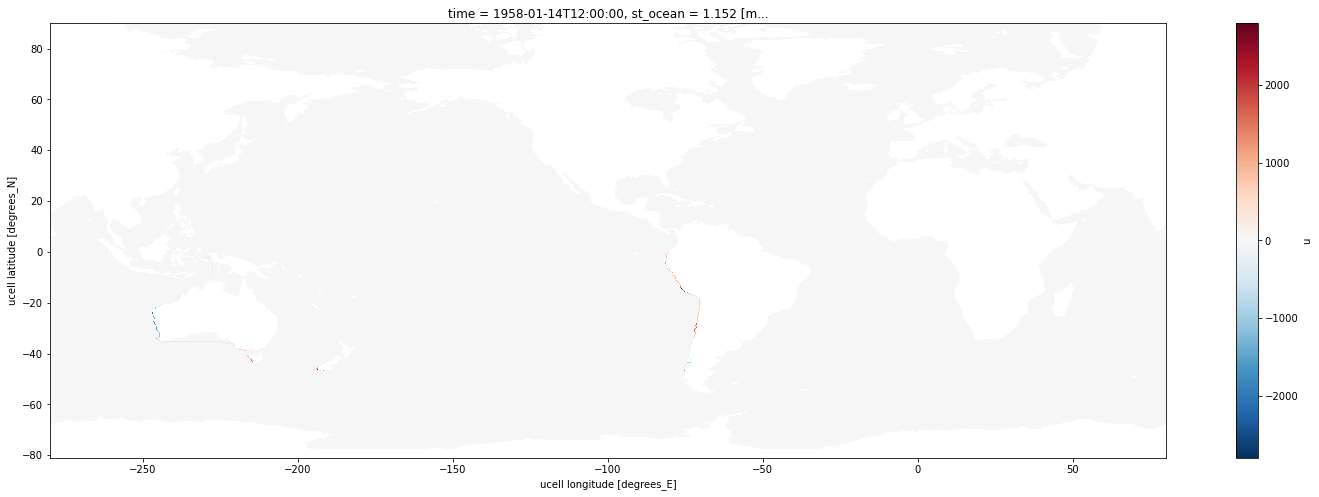

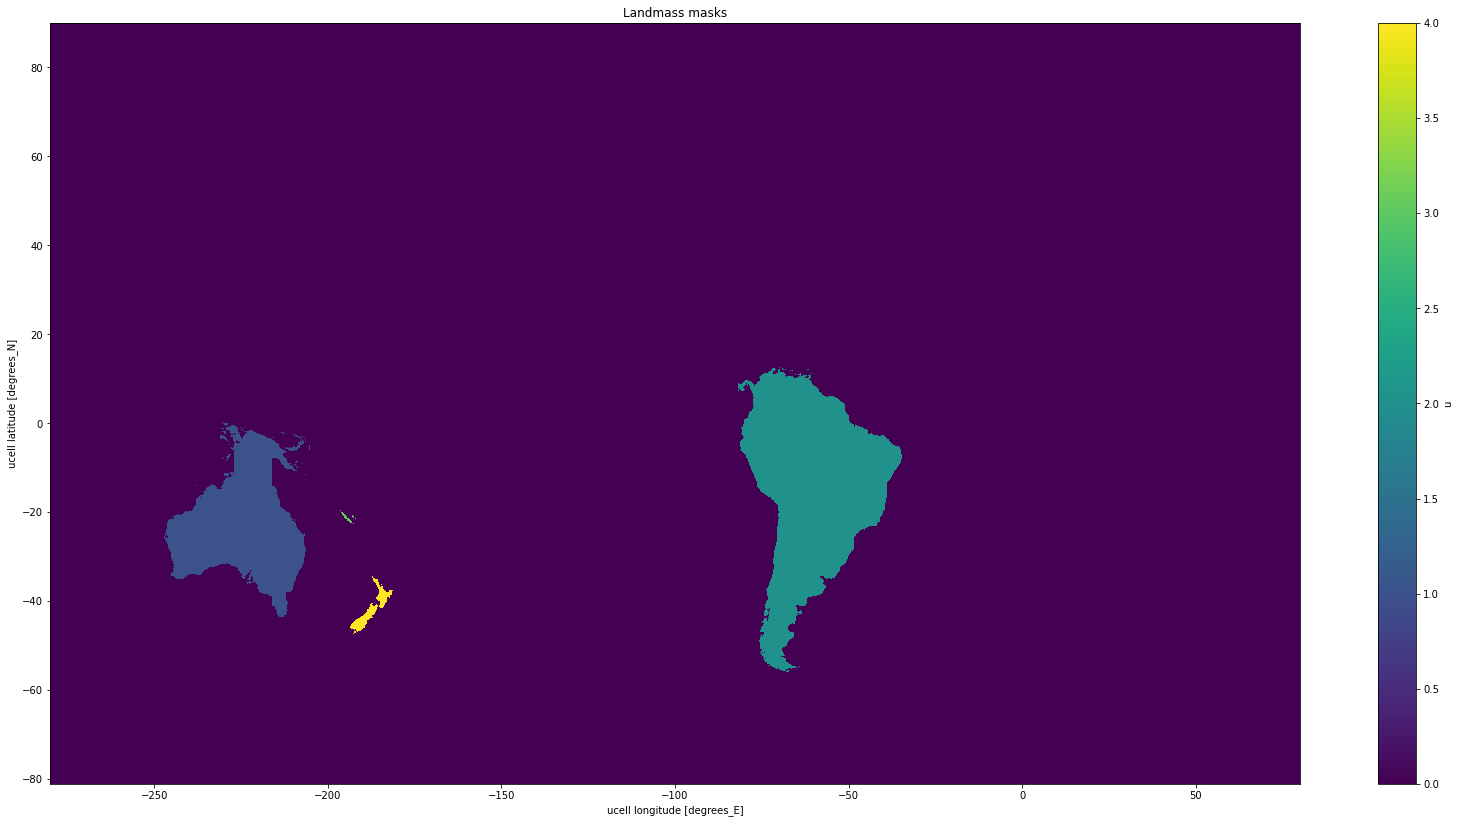

<Figure size 432x288 with 0 Axes>

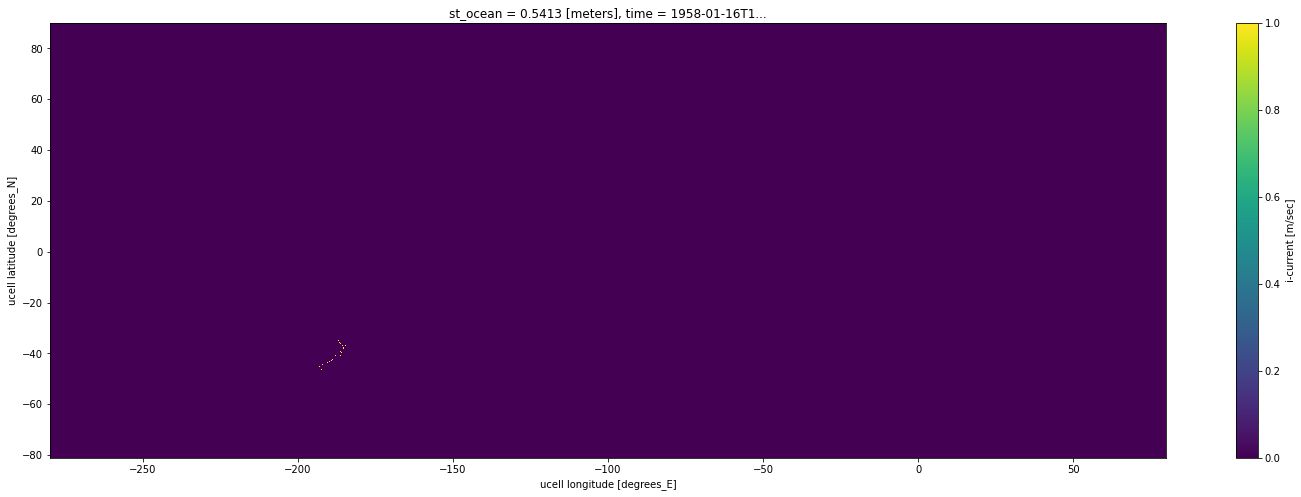

<Figure size 432x288 with 0 Axes>

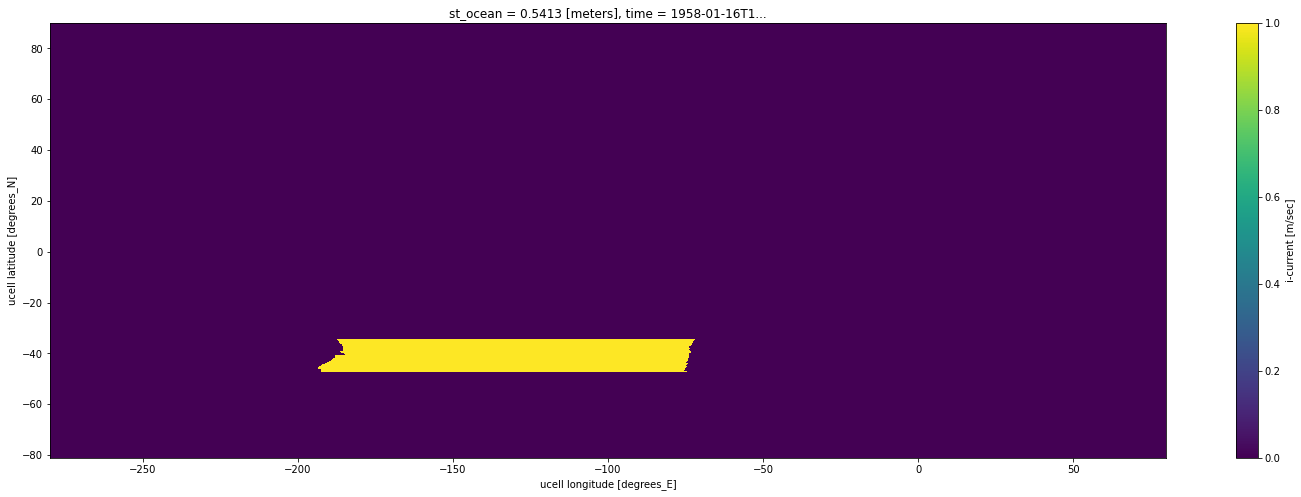

<Figure size 432x288 with 0 Axes>

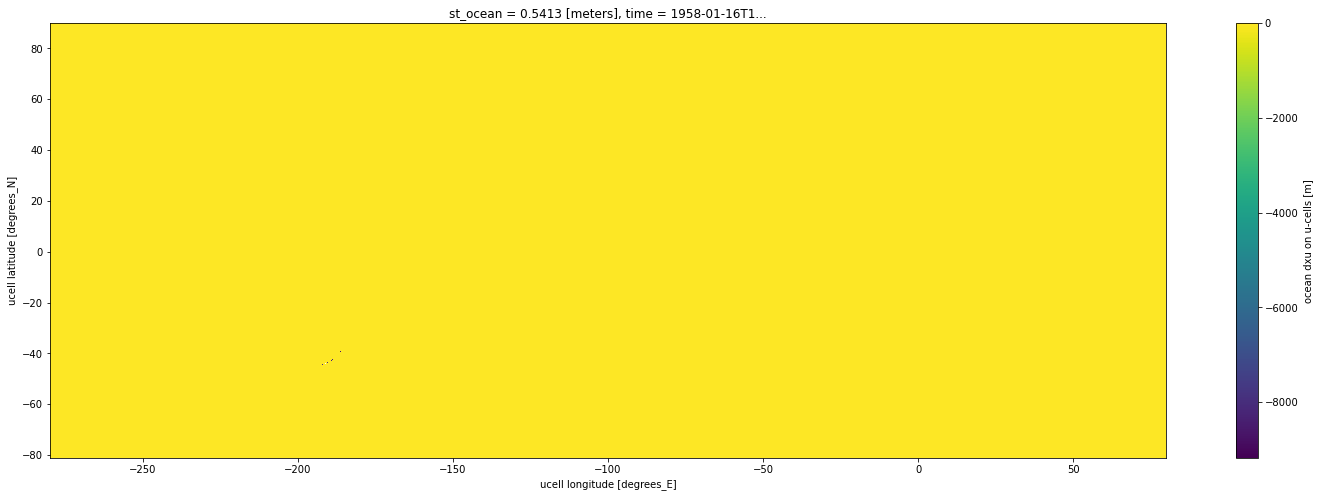

<Figure size 432x288 with 0 Axes>

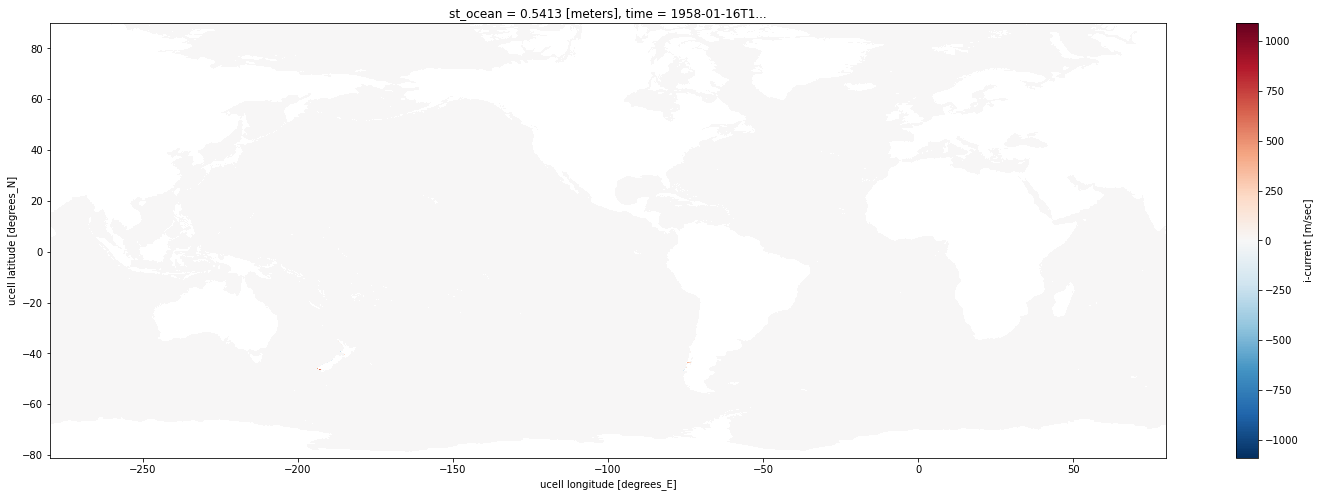

<Figure size 432x288 with 0 Axes>

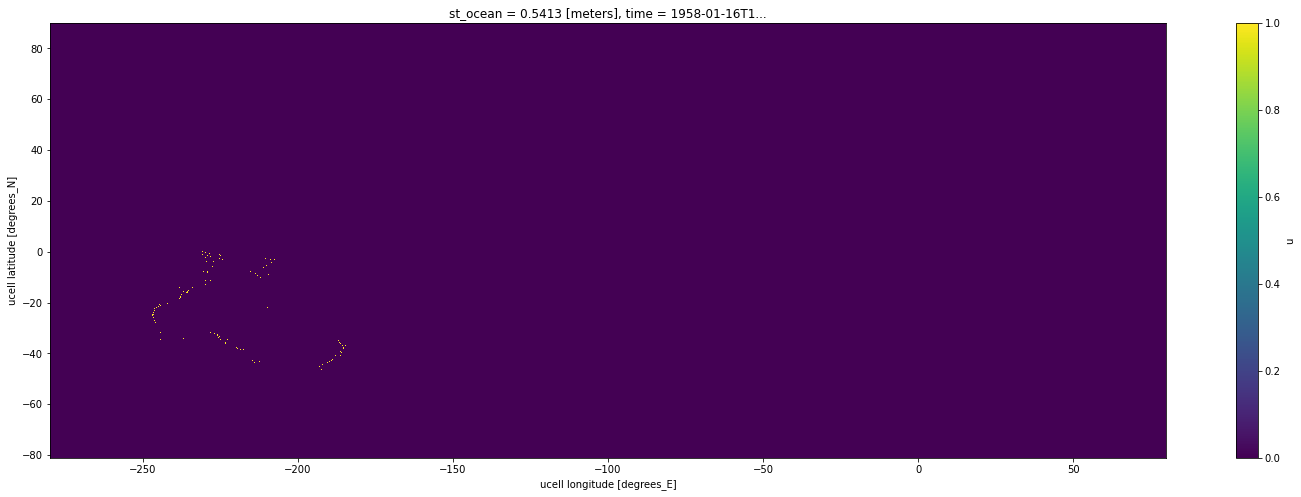

<Figure size 432x288 with 0 Axes>

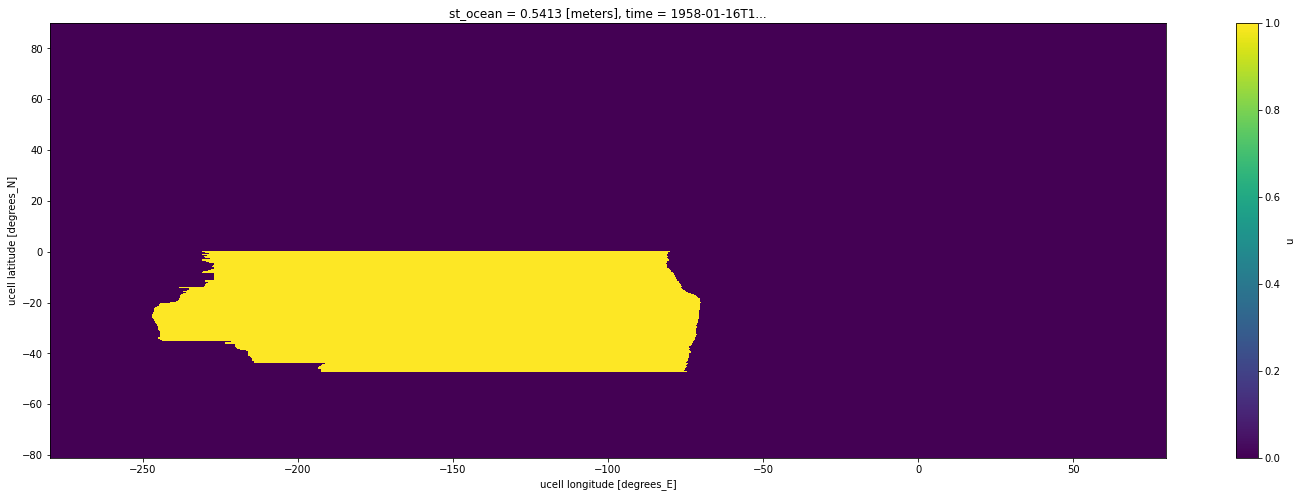

<Figure size 432x288 with 0 Axes>

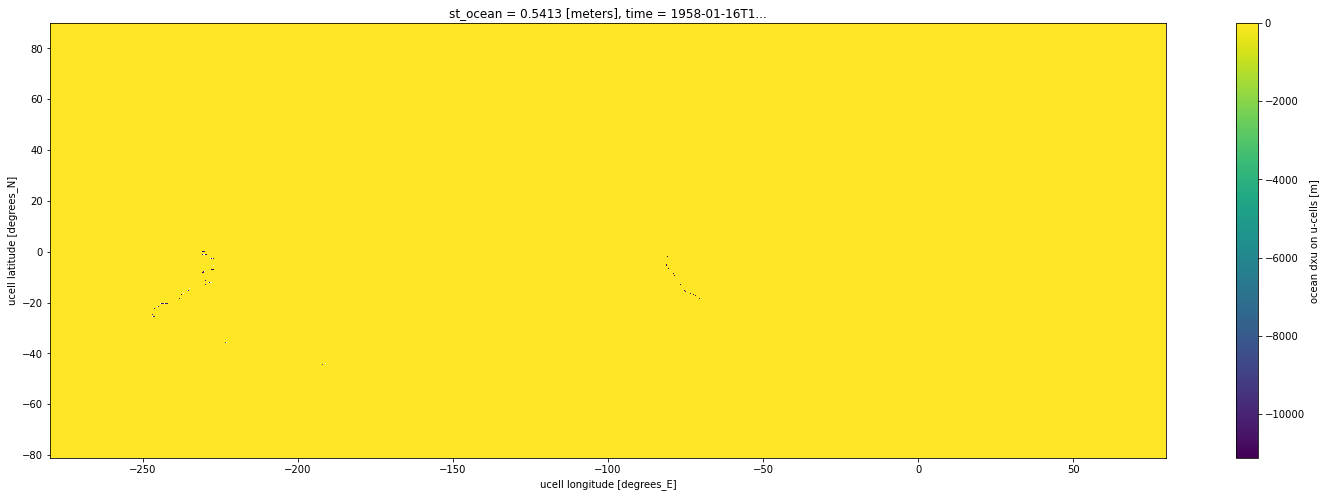

<Figure size 432x288 with 0 Axes>

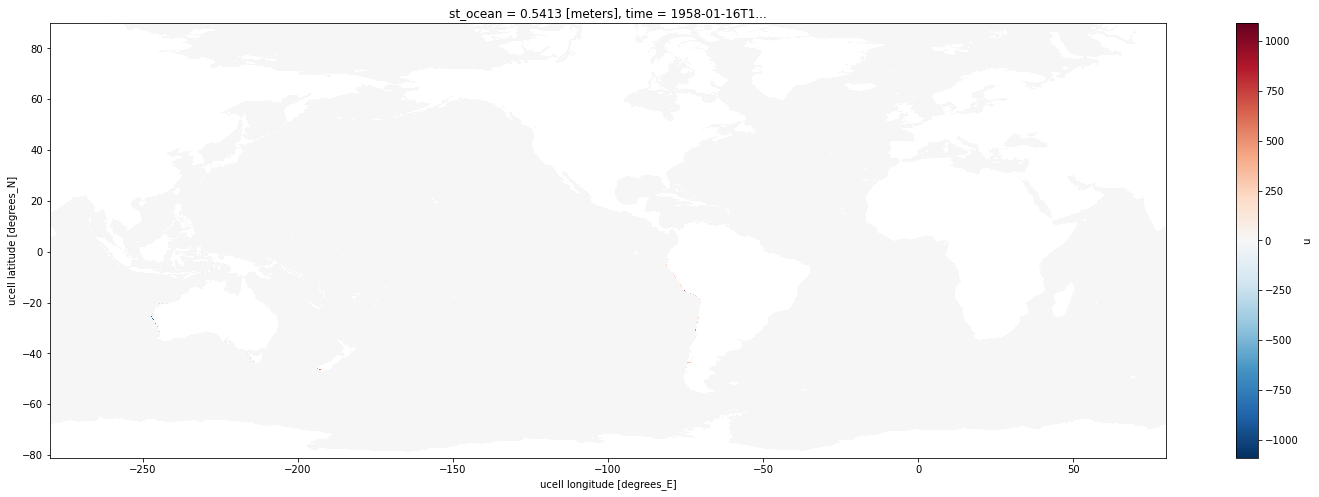

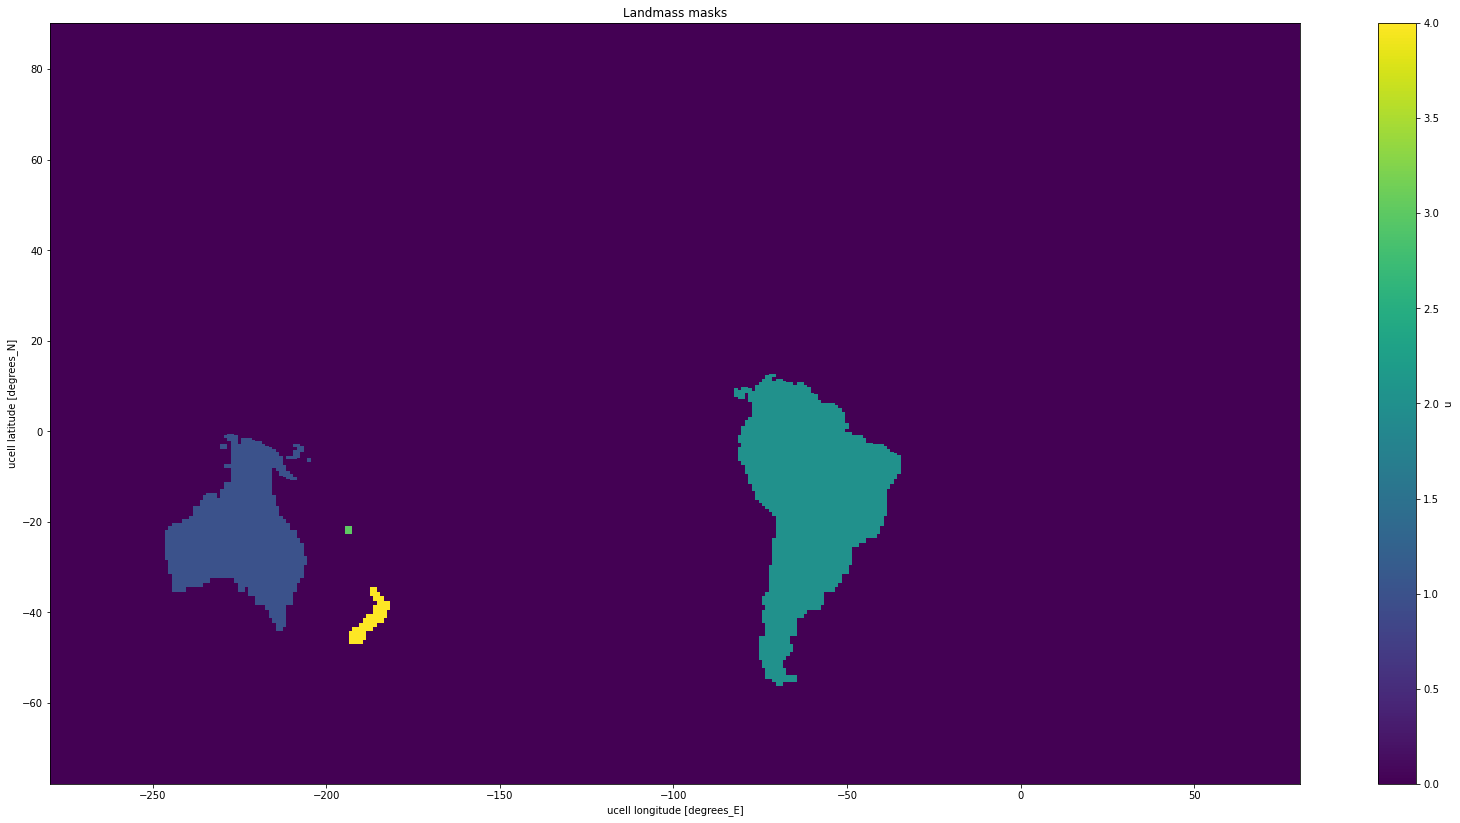

<Figure size 432x288 with 0 Axes>

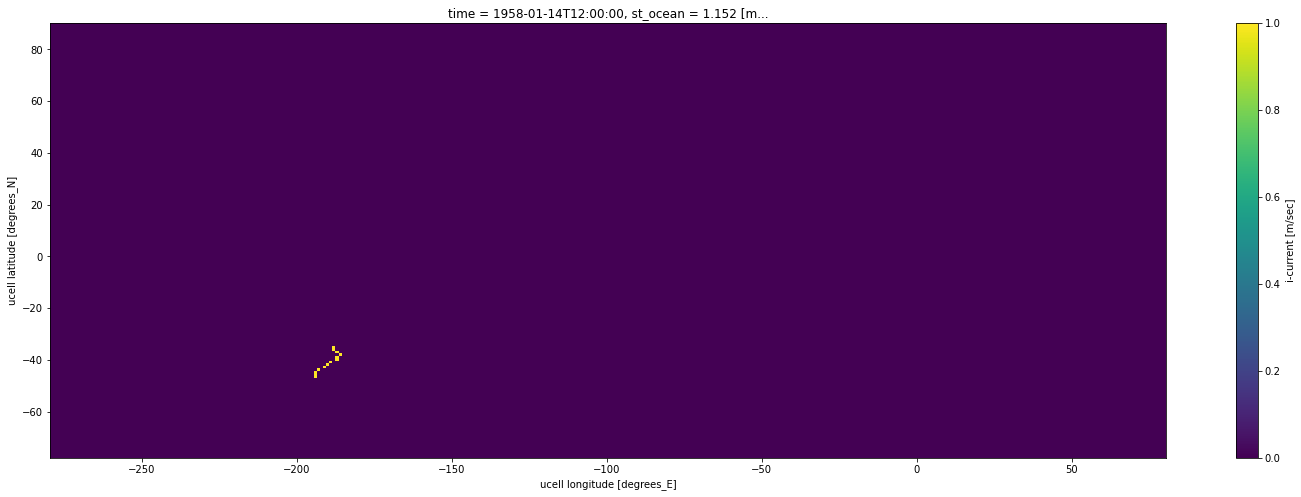

<Figure size 432x288 with 0 Axes>

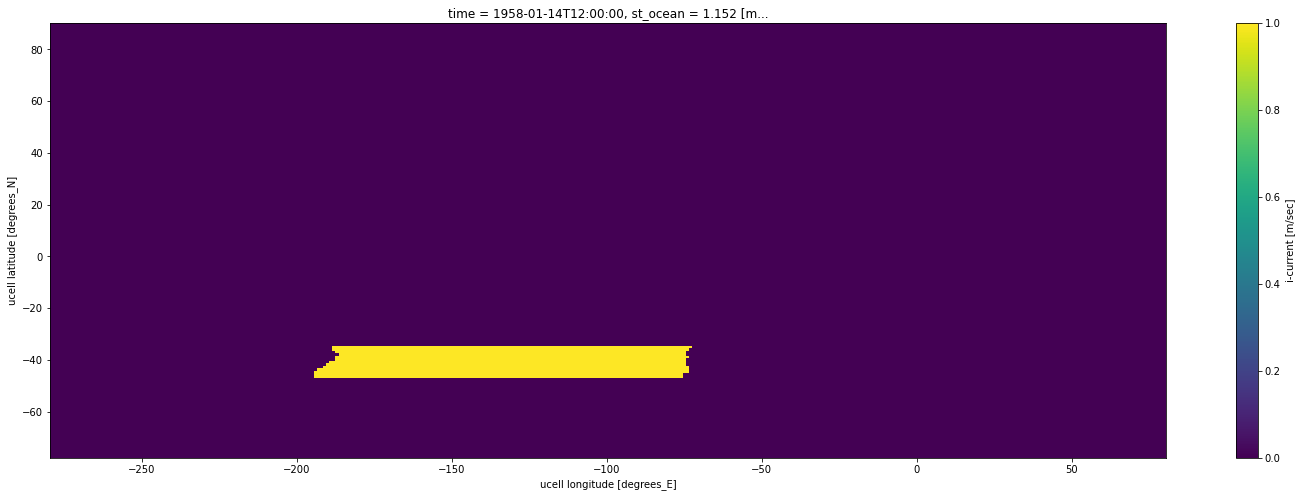

<Figure size 432x288 with 0 Axes>

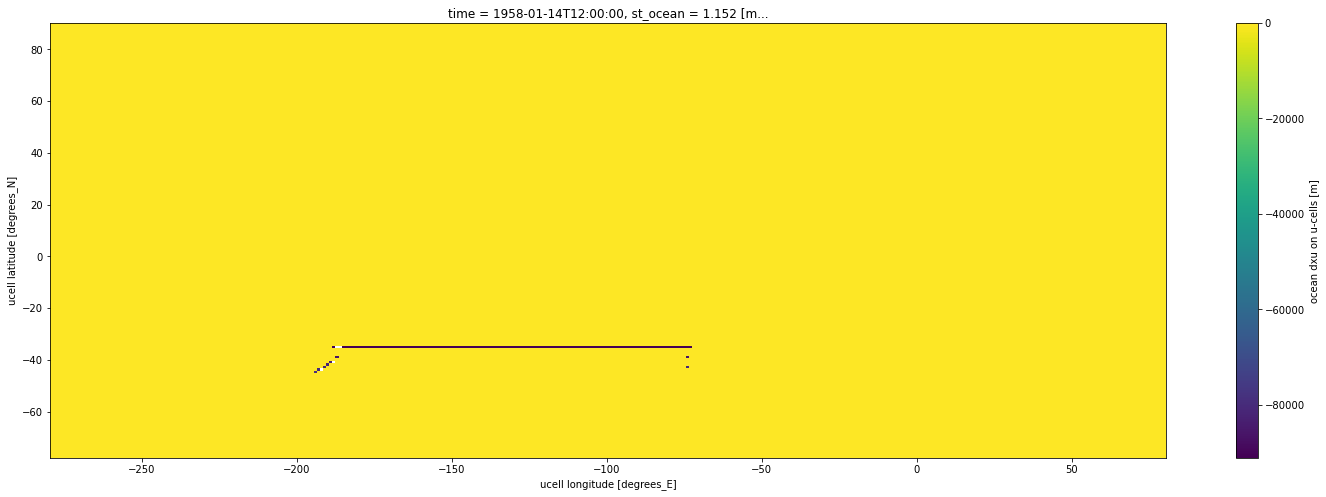

<Figure size 432x288 with 0 Axes>

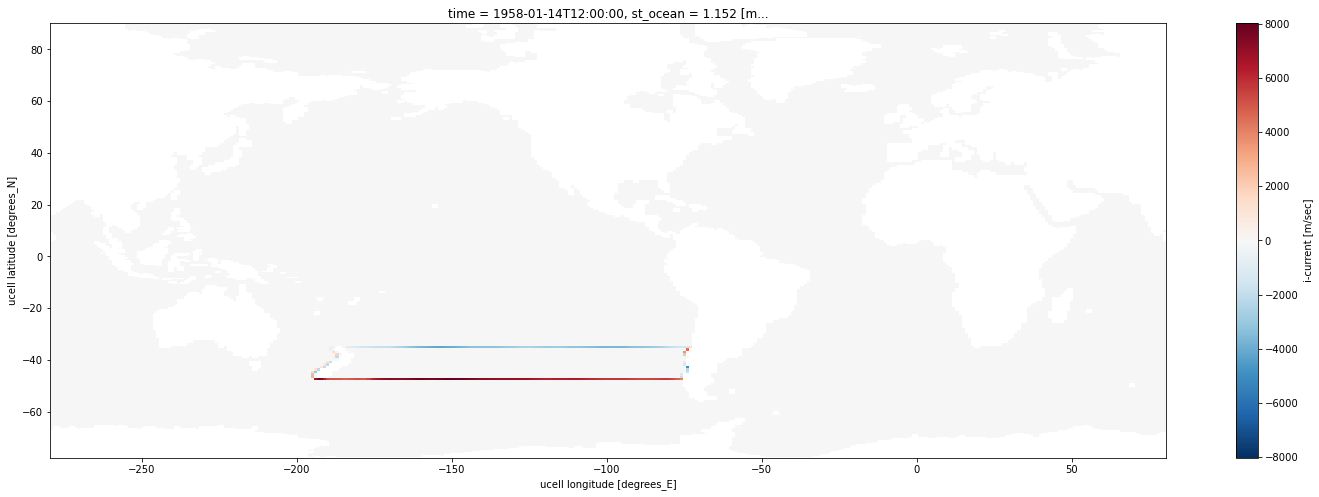

<Figure size 432x288 with 0 Axes>

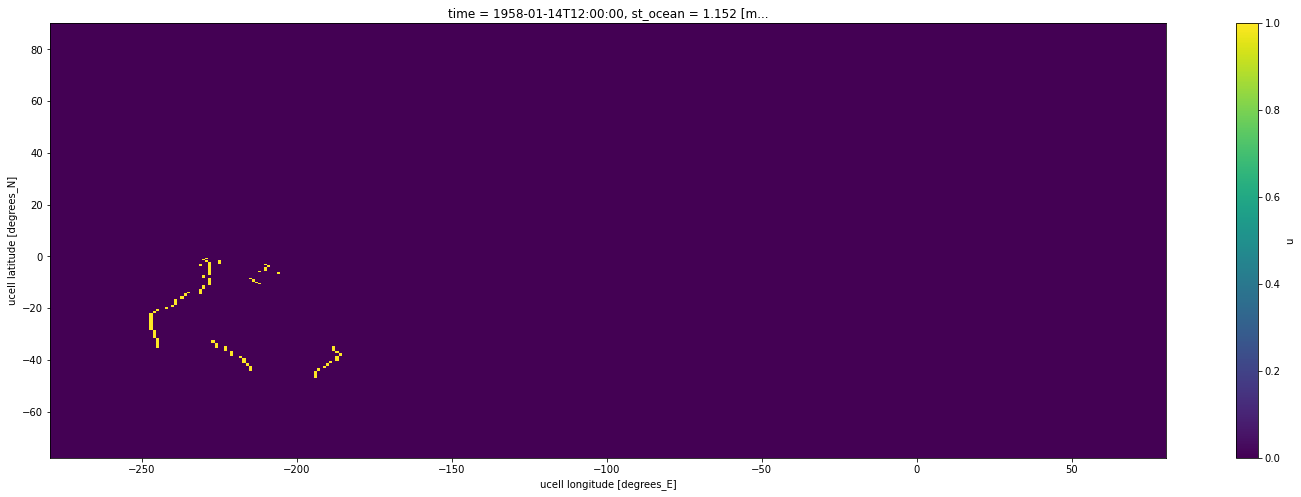

<Figure size 432x288 with 0 Axes>

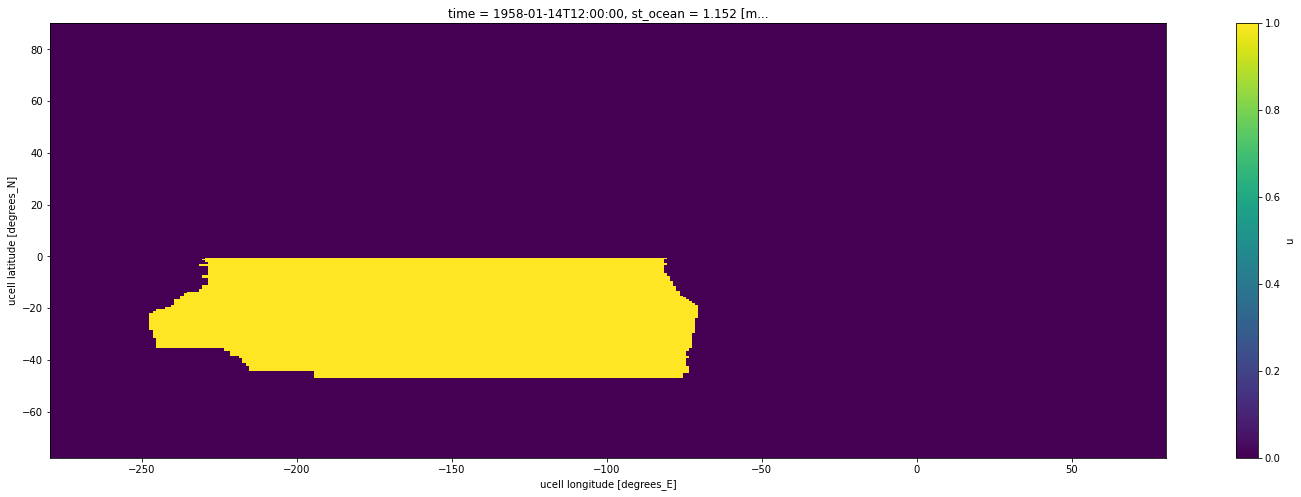

<Figure size 432x288 with 0 Axes>

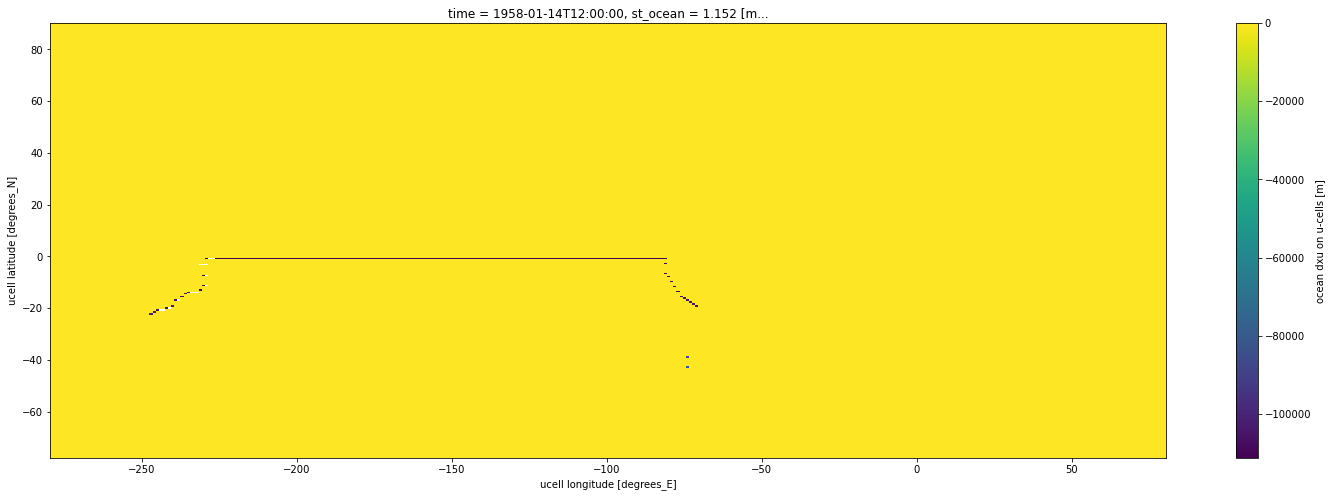

<Figure size 432x288 with 0 Axes>

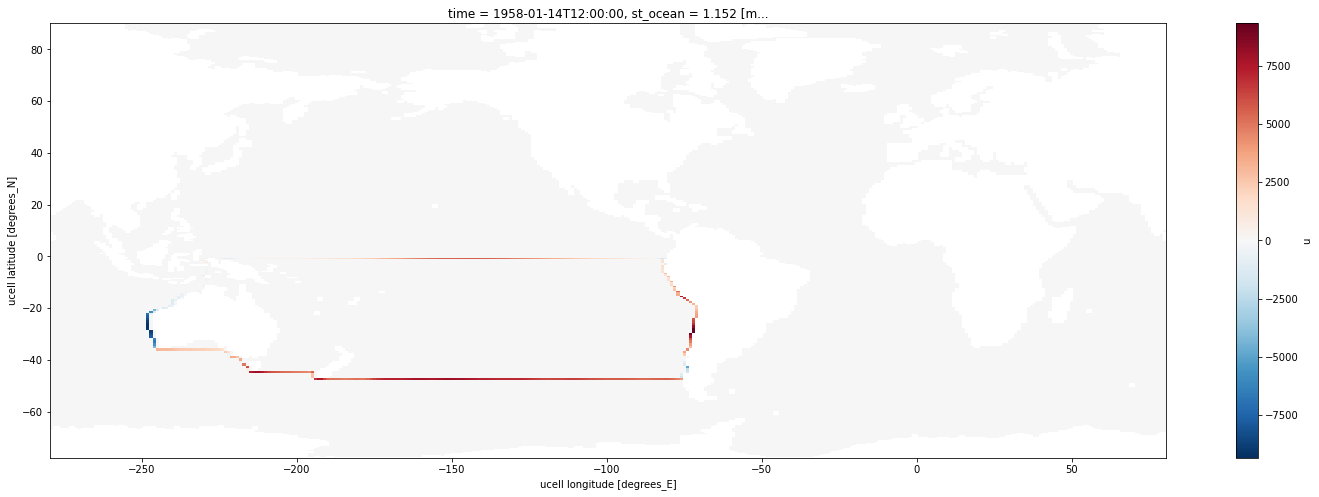

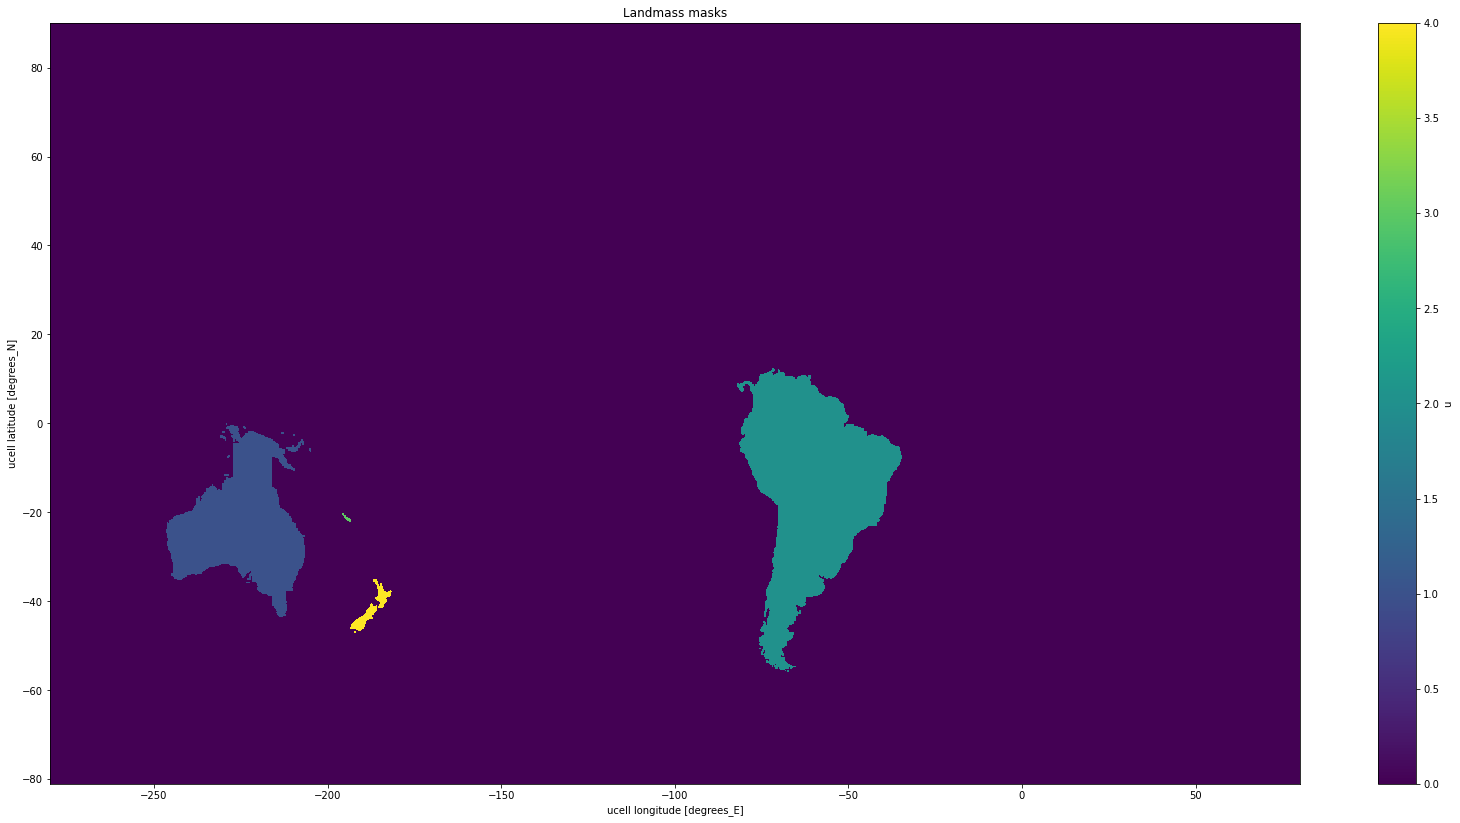

<Figure size 432x288 with 0 Axes>

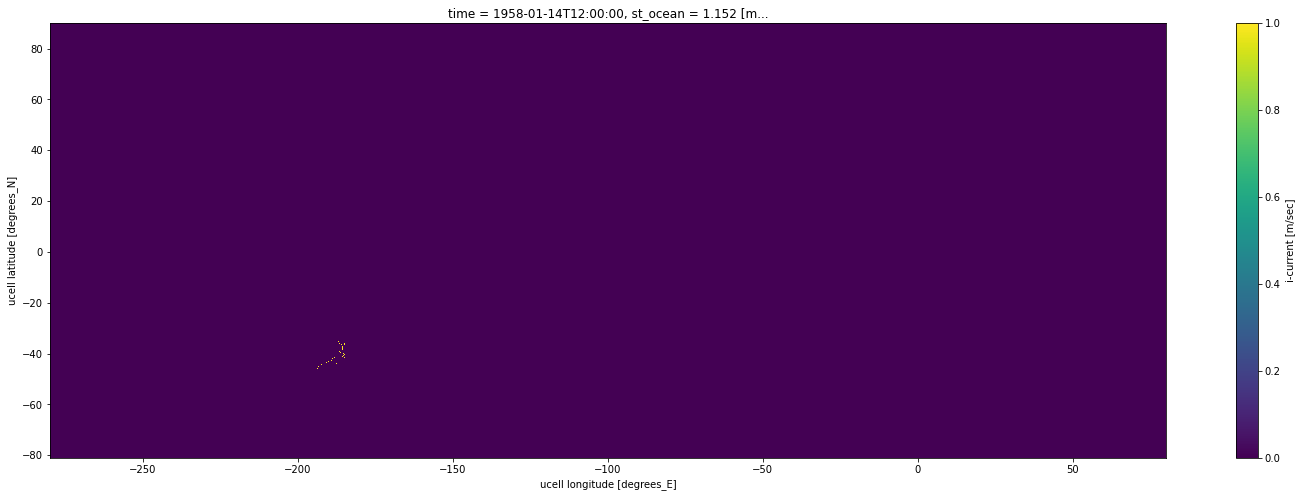

<Figure size 432x288 with 0 Axes>

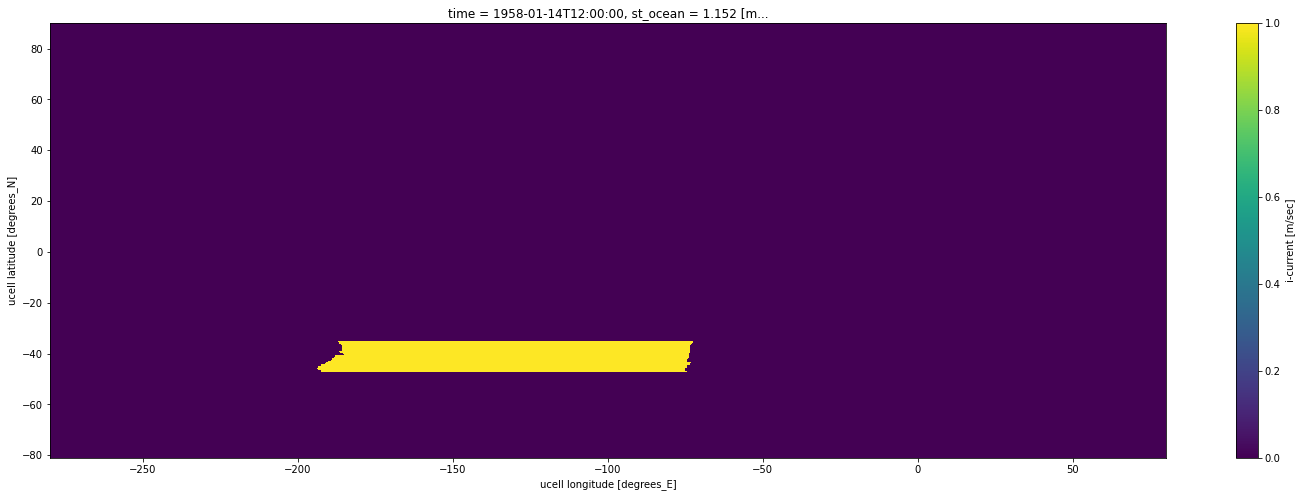

<Figure size 432x288 with 0 Axes>

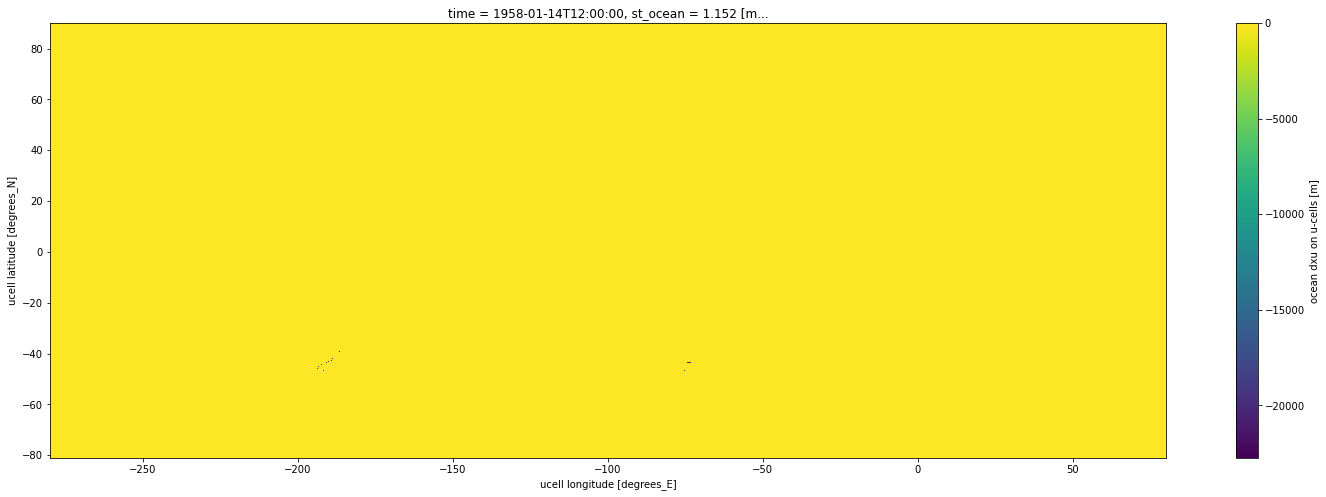

<Figure size 432x288 with 0 Axes>

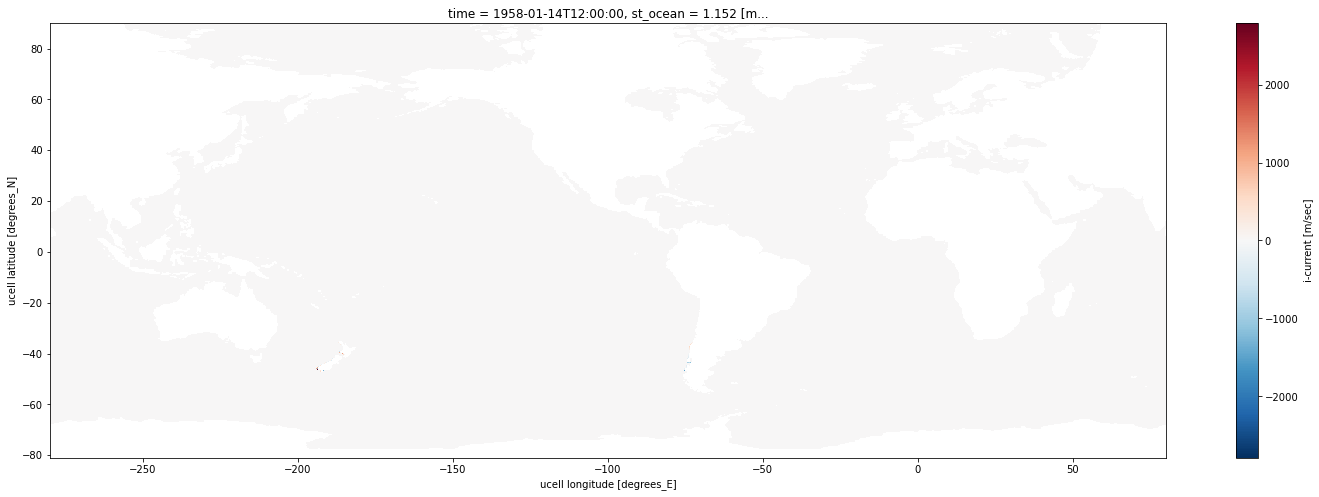

<Figure size 432x288 with 0 Axes>

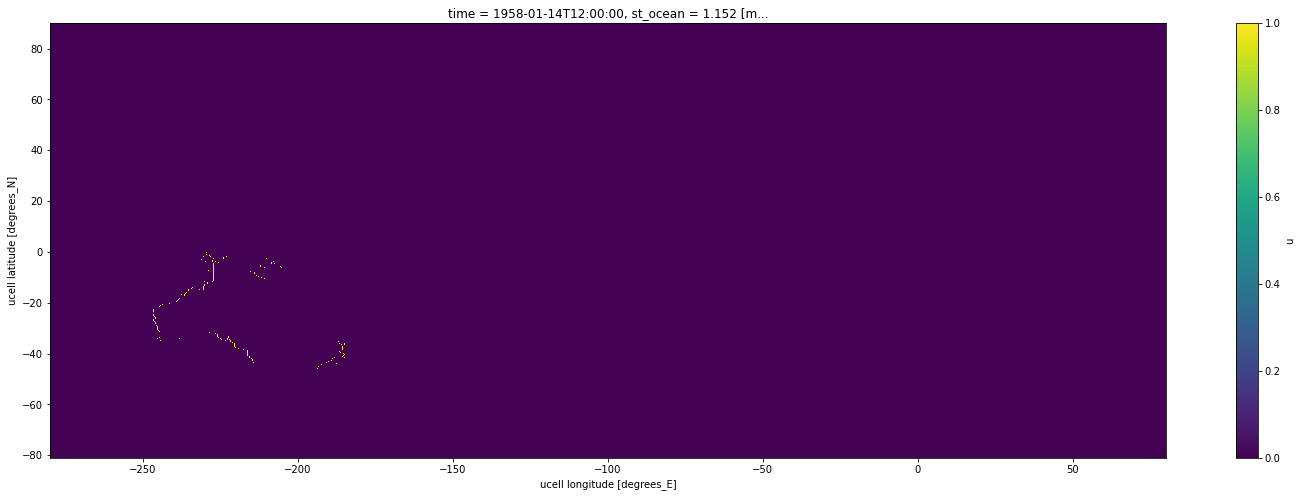

<Figure size 432x288 with 0 Axes>

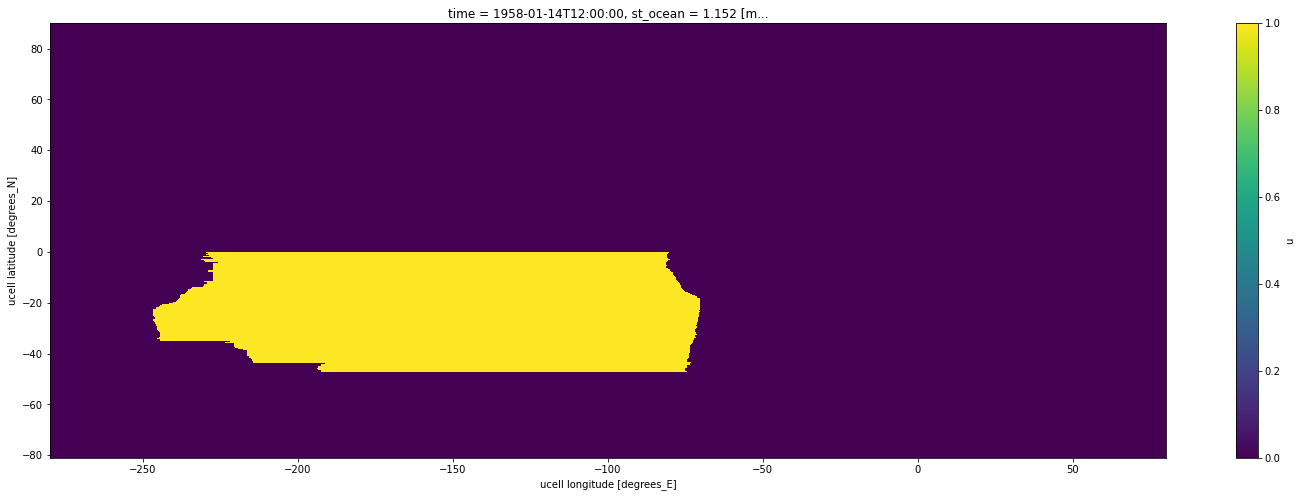

<Figure size 432x288 with 0 Axes>

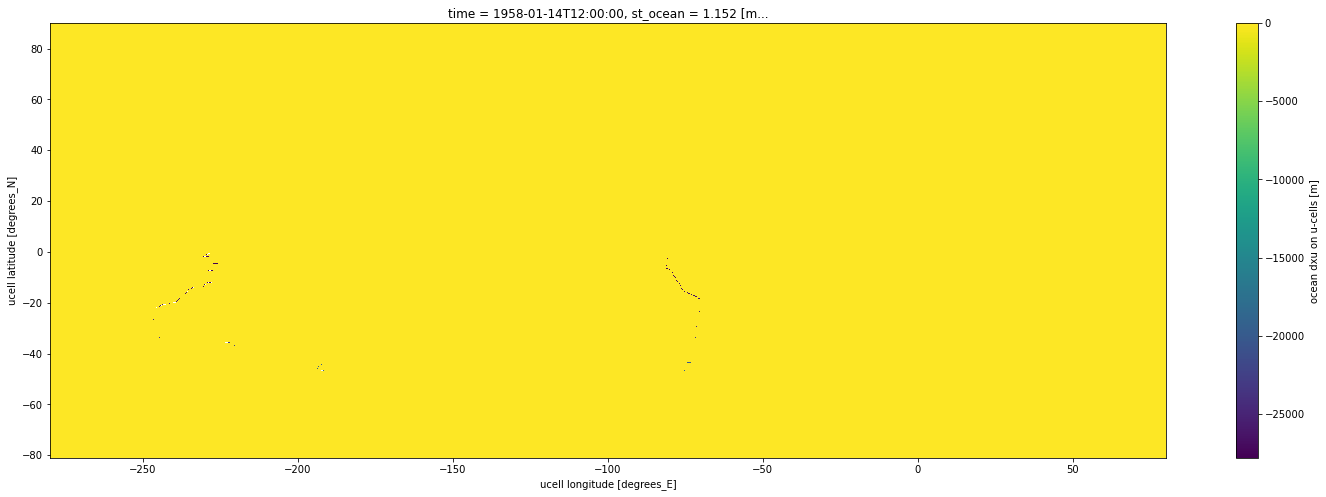

<Figure size 432x288 with 0 Axes>

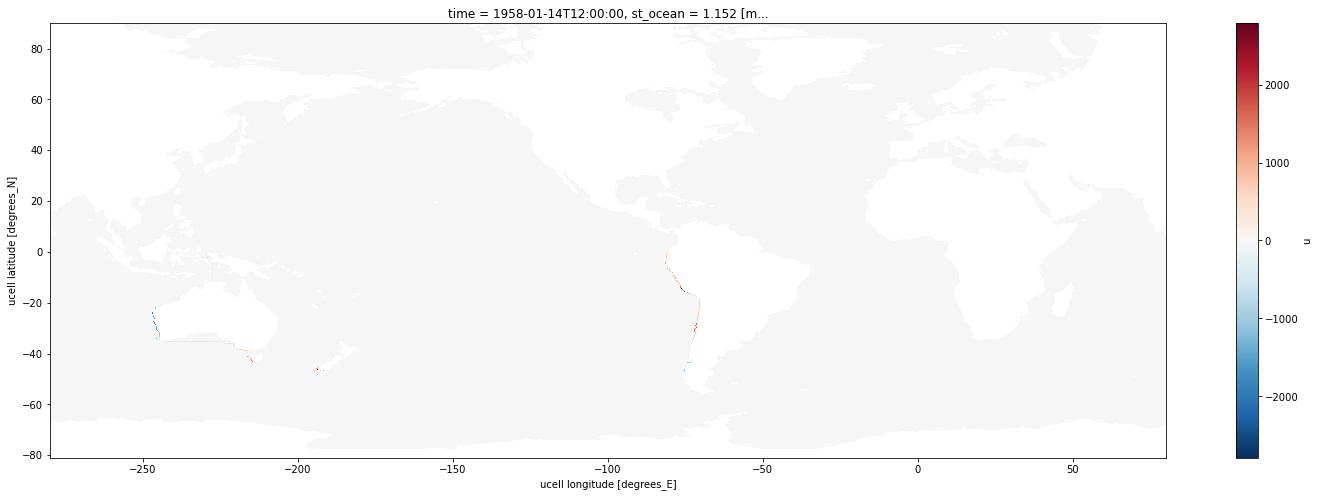

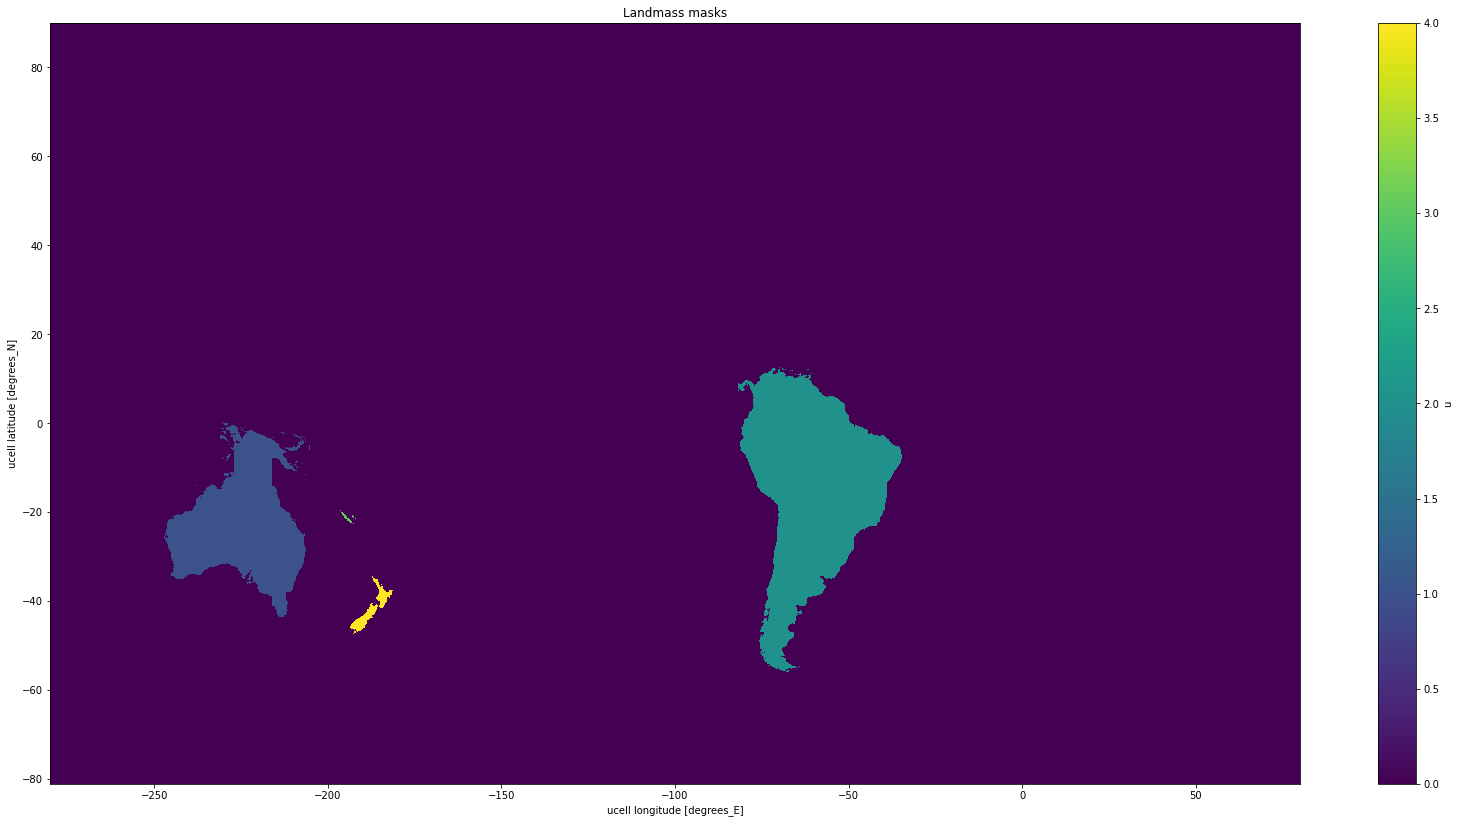

<Figure size 432x288 with 0 Axes>

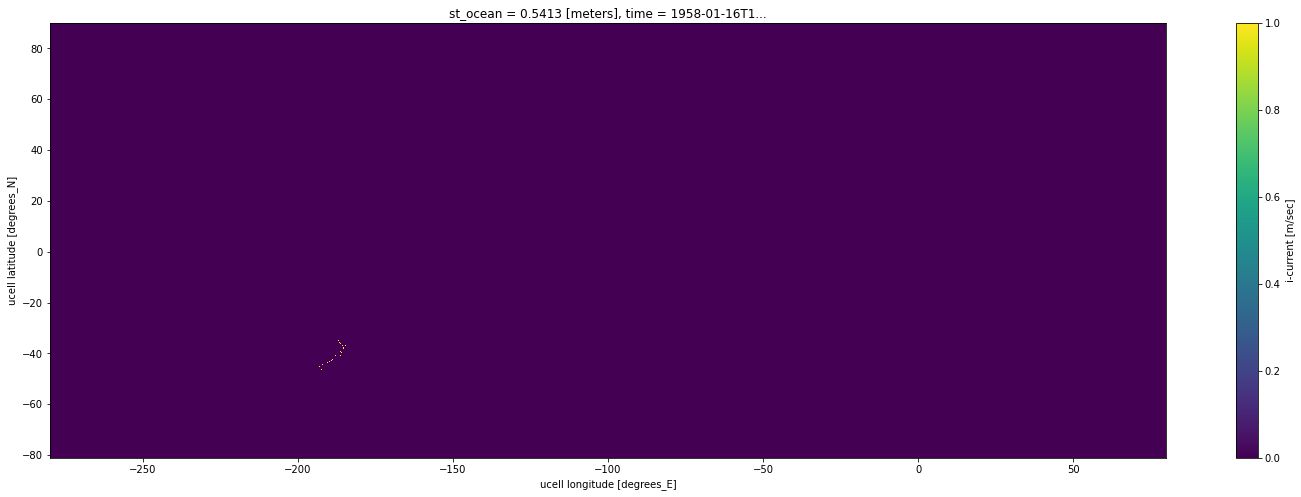

<Figure size 432x288 with 0 Axes>

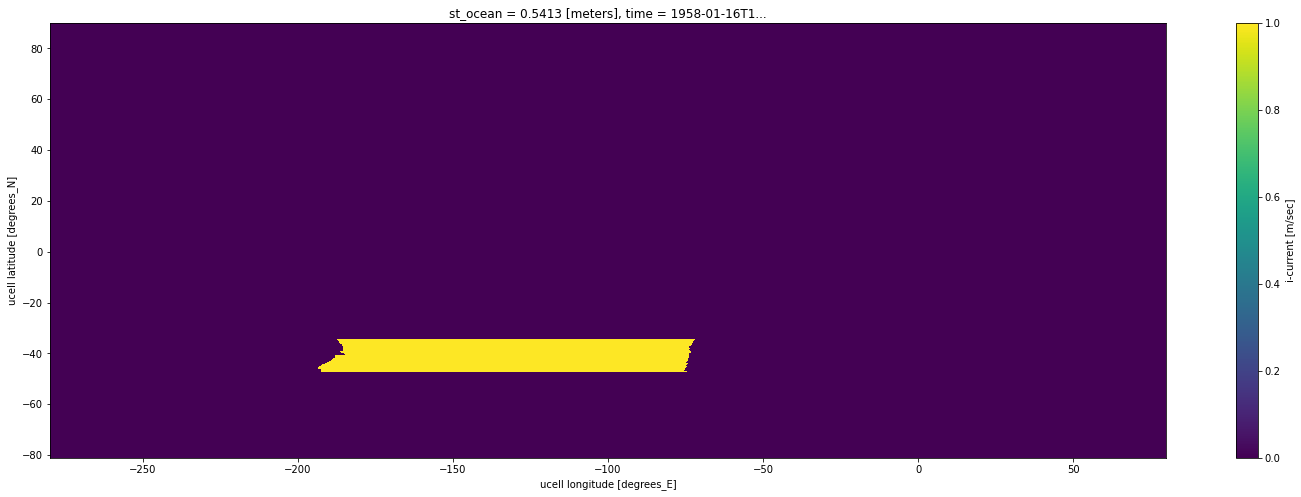

<Figure size 432x288 with 0 Axes>

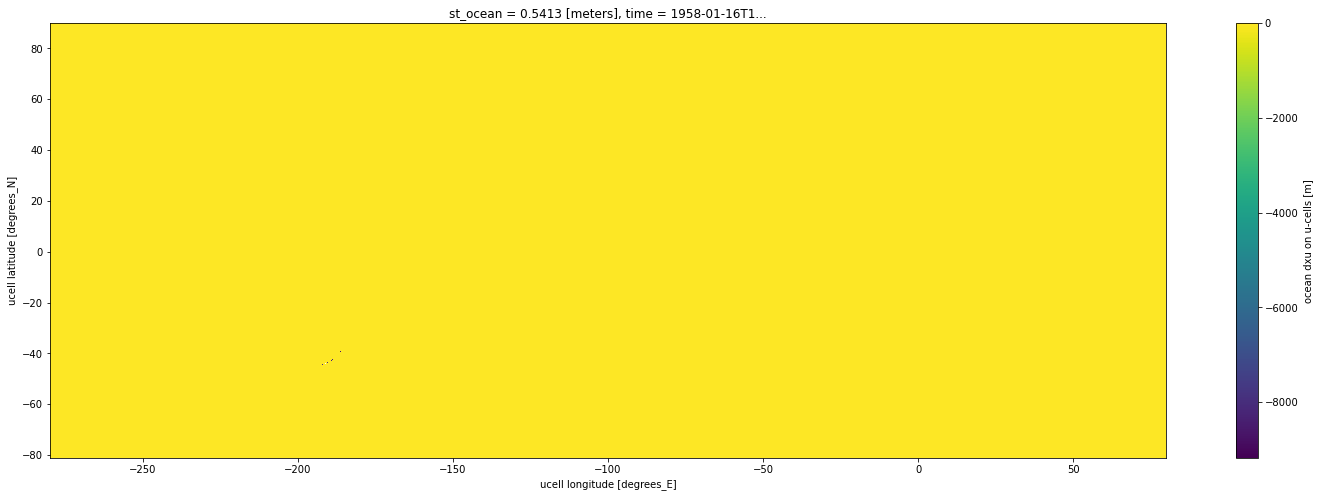

<Figure size 432x288 with 0 Axes>

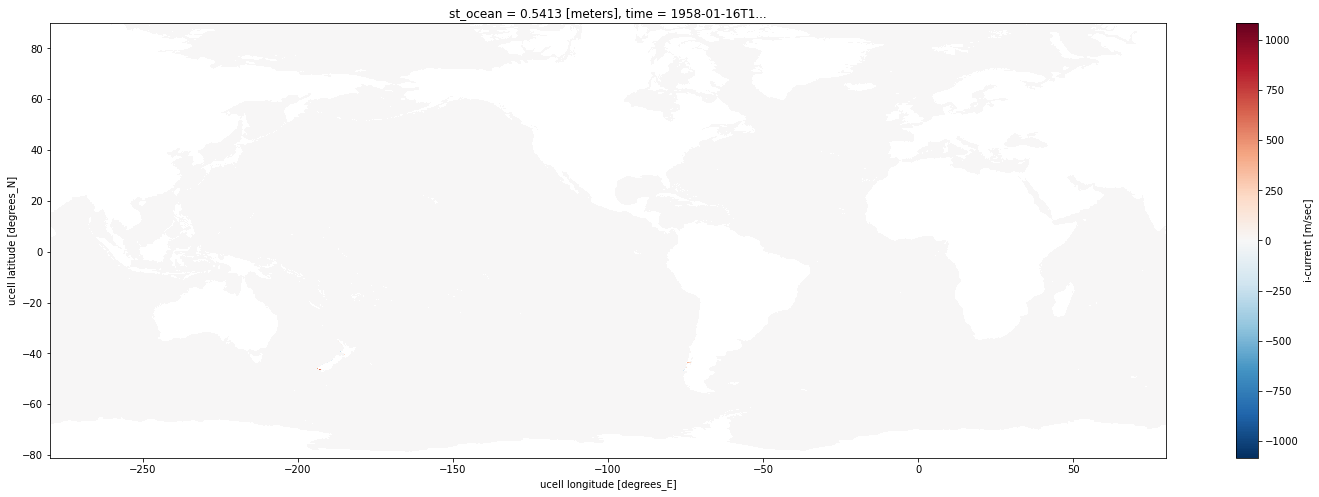

<Figure size 432x288 with 0 Axes>

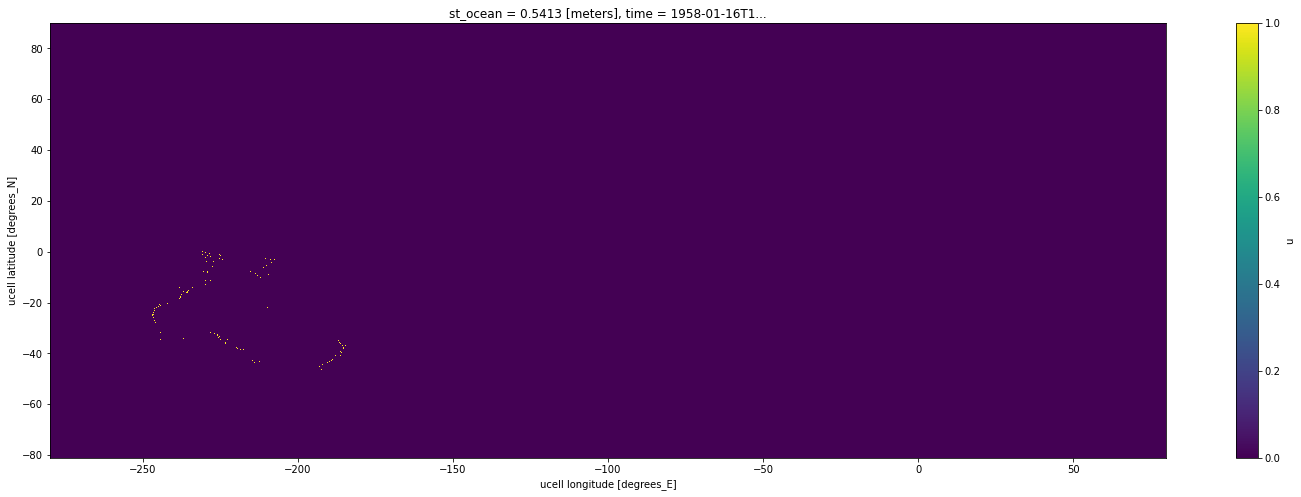

<Figure size 432x288 with 0 Axes>

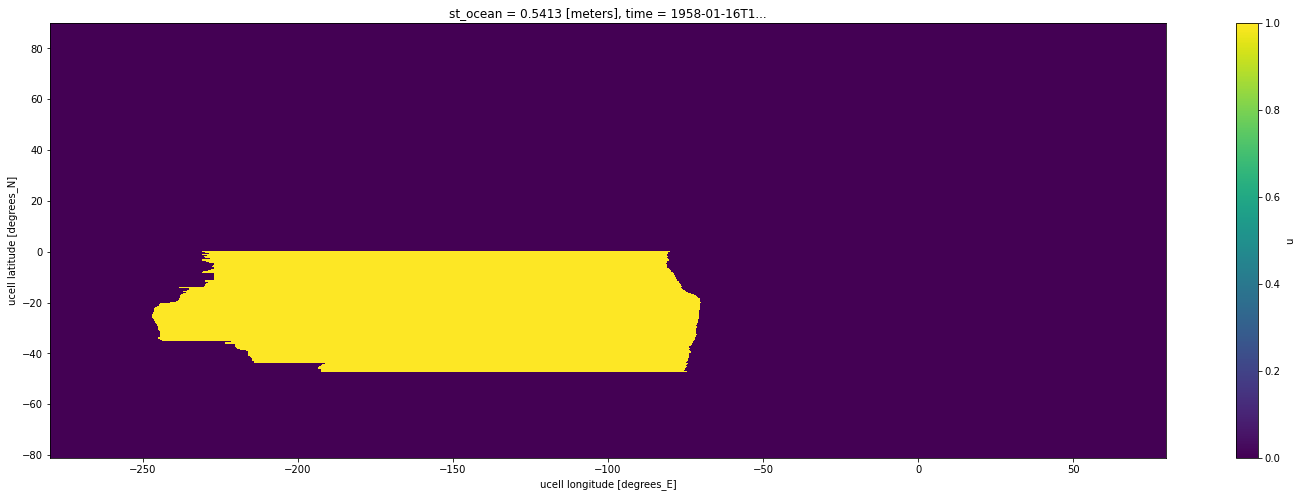

<Figure size 432x288 with 0 Axes>

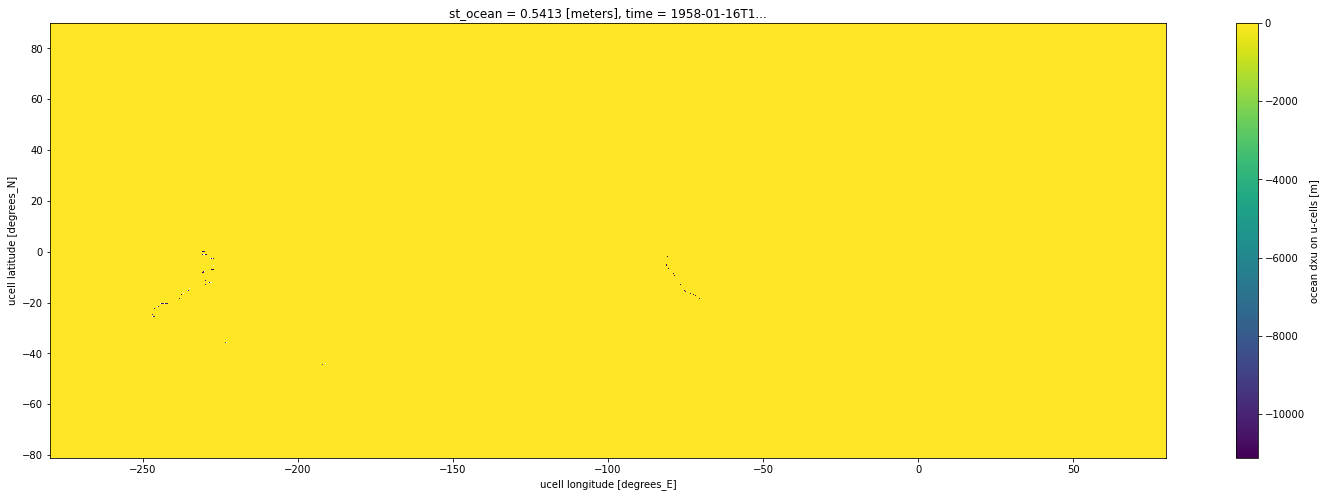

<Figure size 432x288 with 0 Axes>

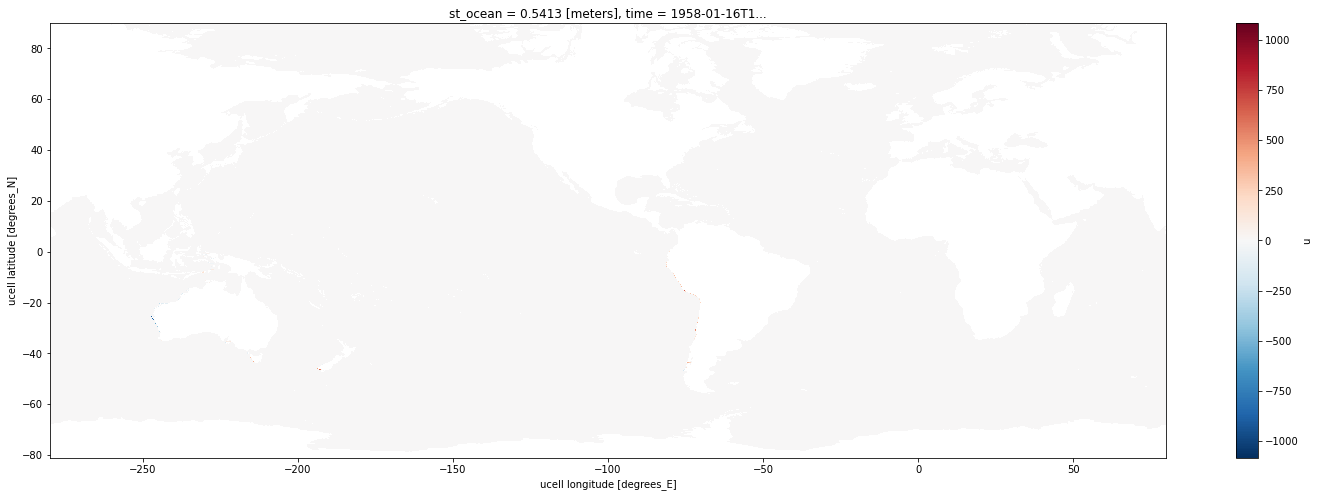

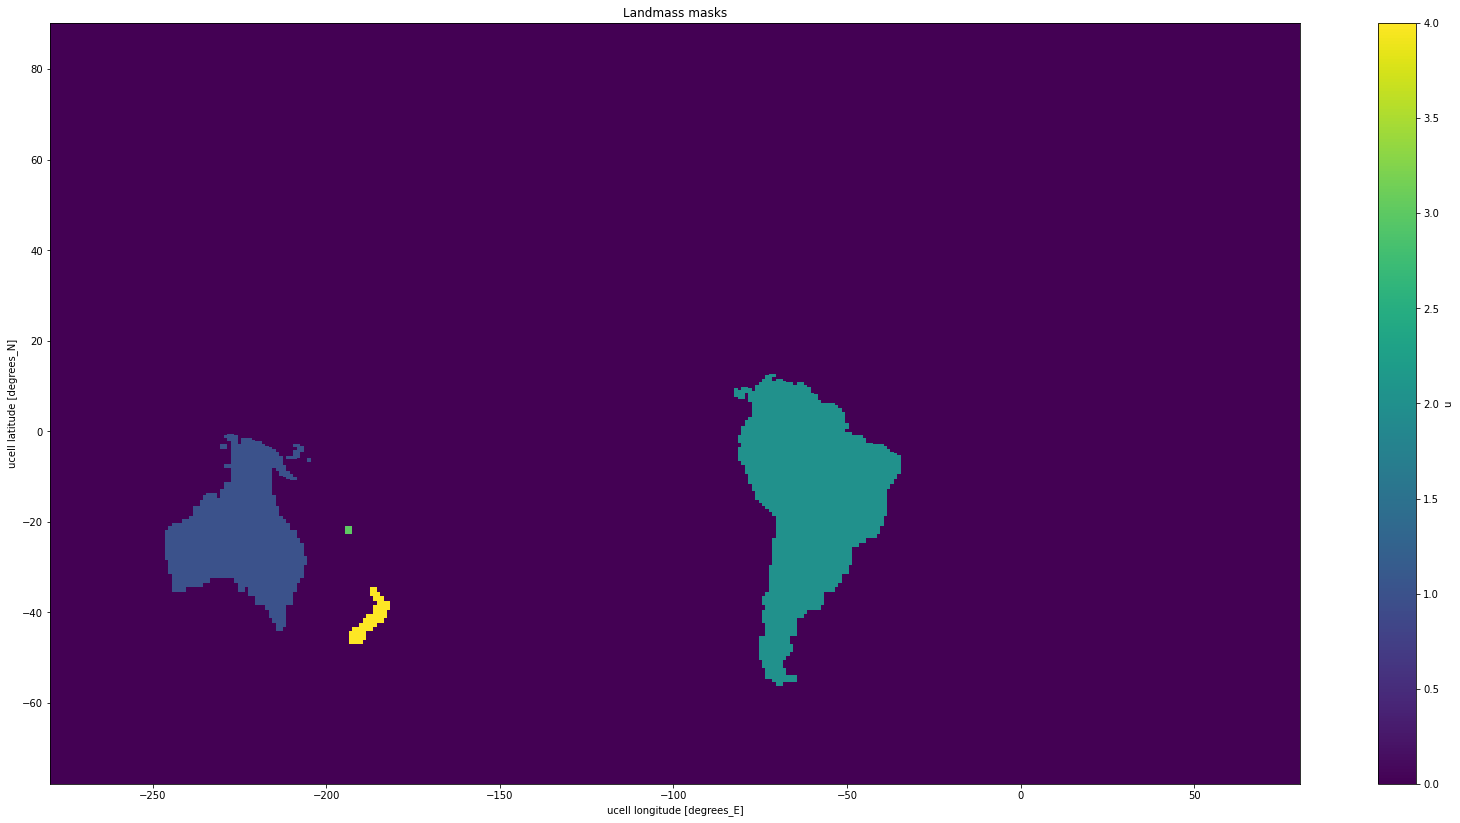

<Figure size 432x288 with 0 Axes>

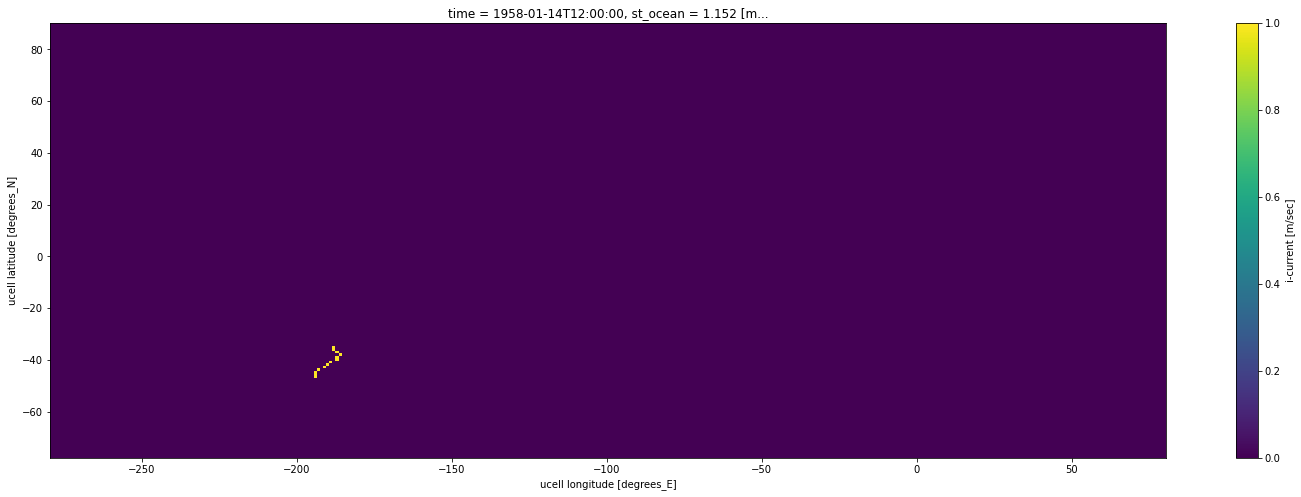

<Figure size 432x288 with 0 Axes>

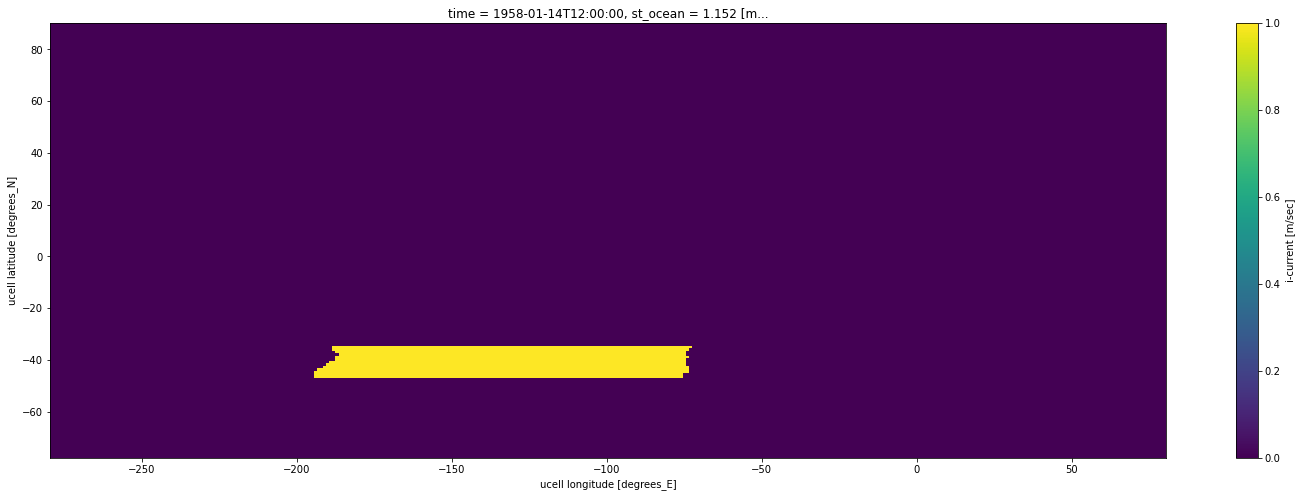

<Figure size 432x288 with 0 Axes>

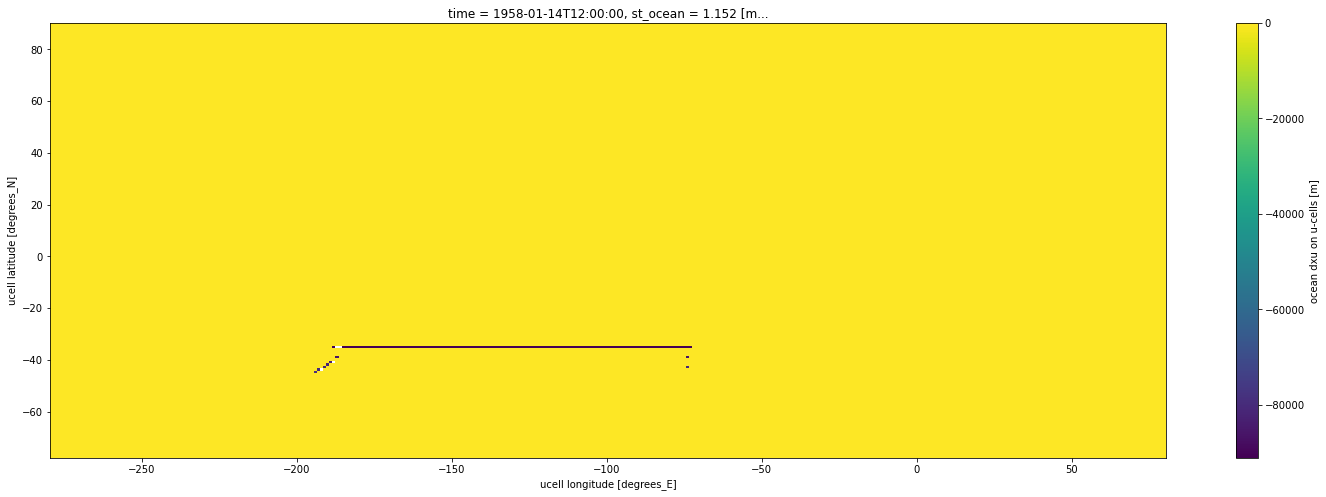

<Figure size 432x288 with 0 Axes>

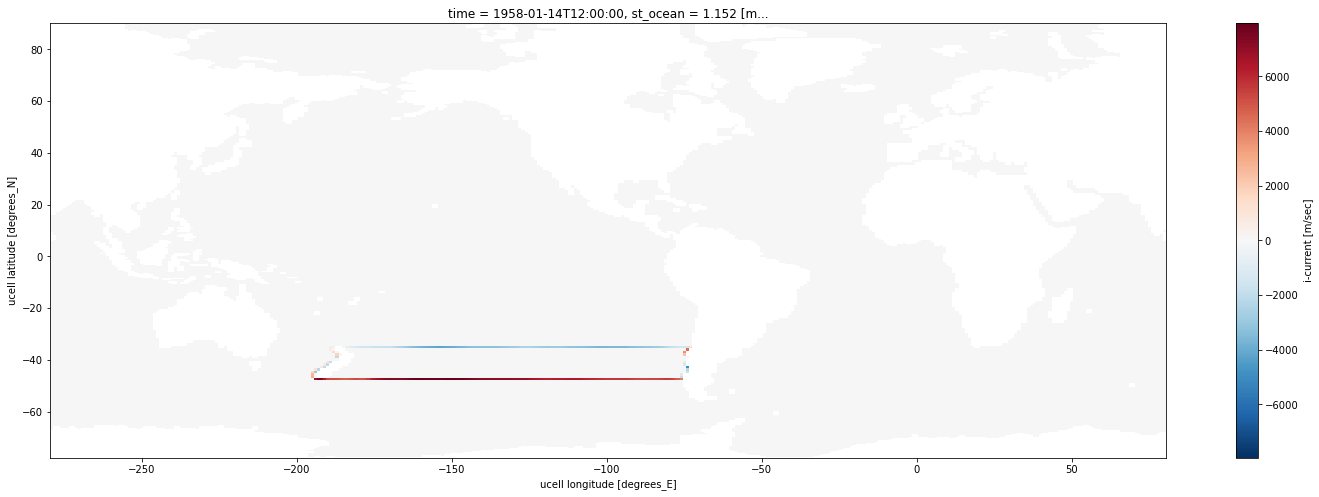

<Figure size 432x288 with 0 Axes>

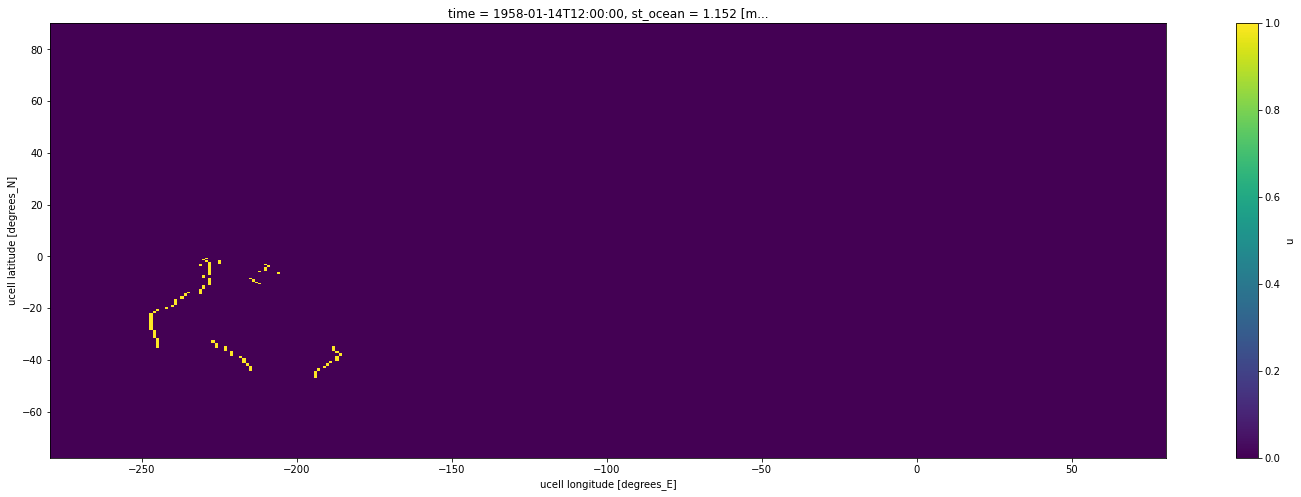

<Figure size 432x288 with 0 Axes>

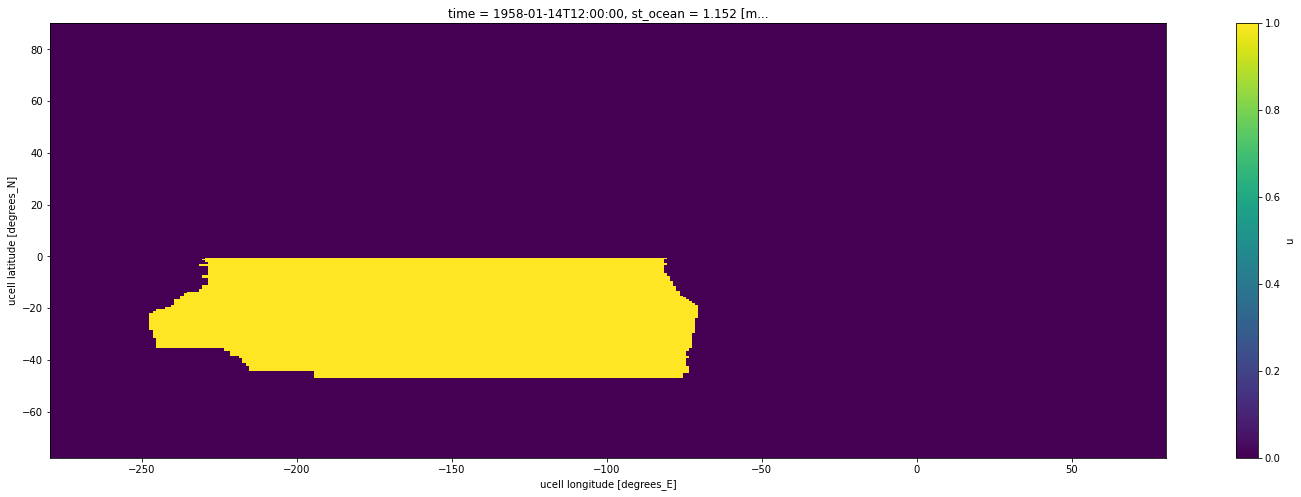

<Figure size 432x288 with 0 Axes>

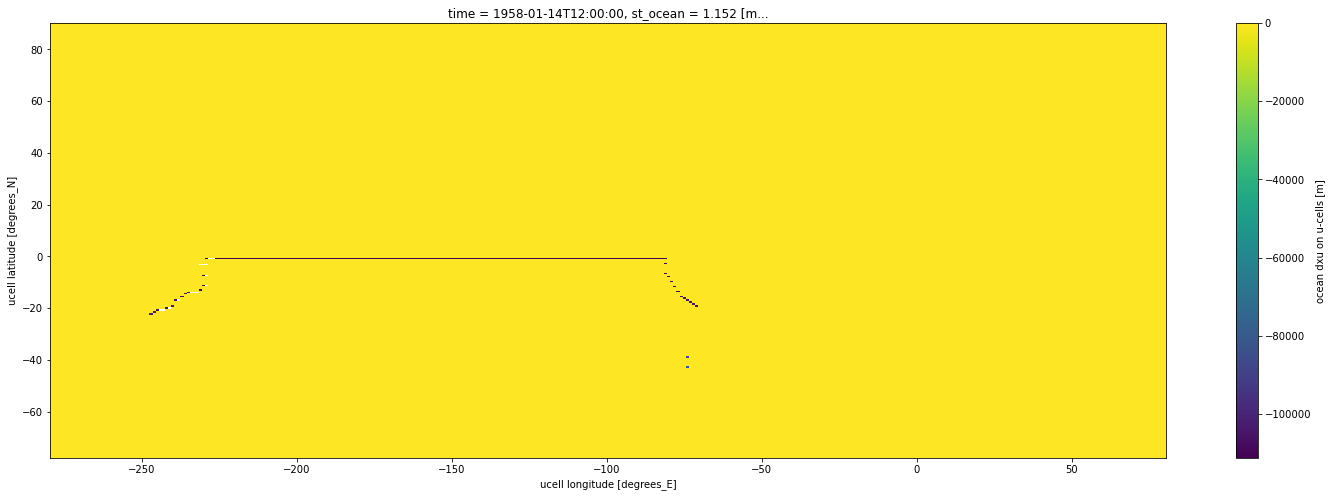

<Figure size 432x288 with 0 Axes>

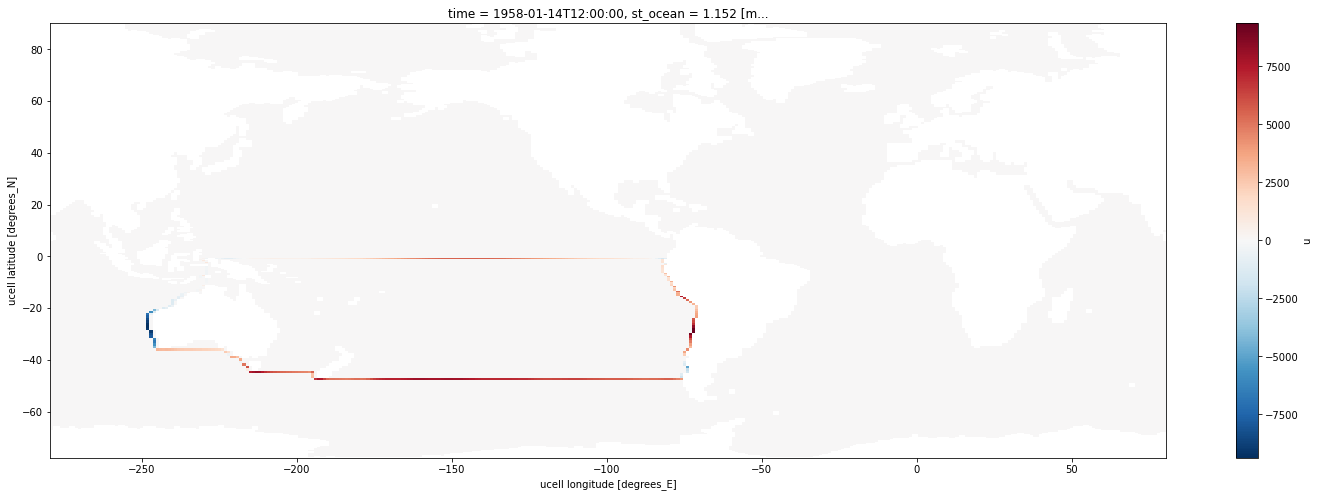

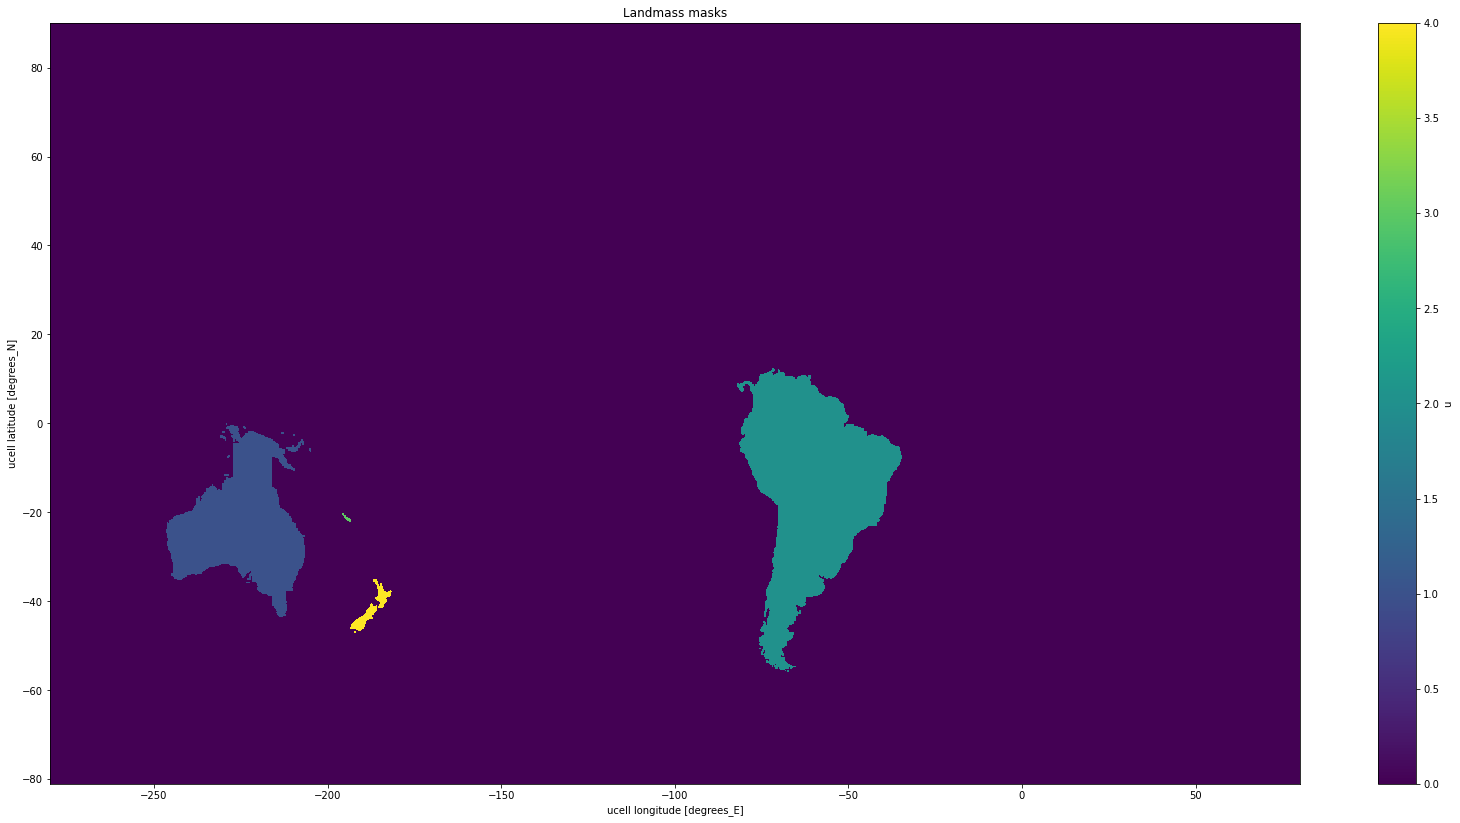

<Figure size 432x288 with 0 Axes>

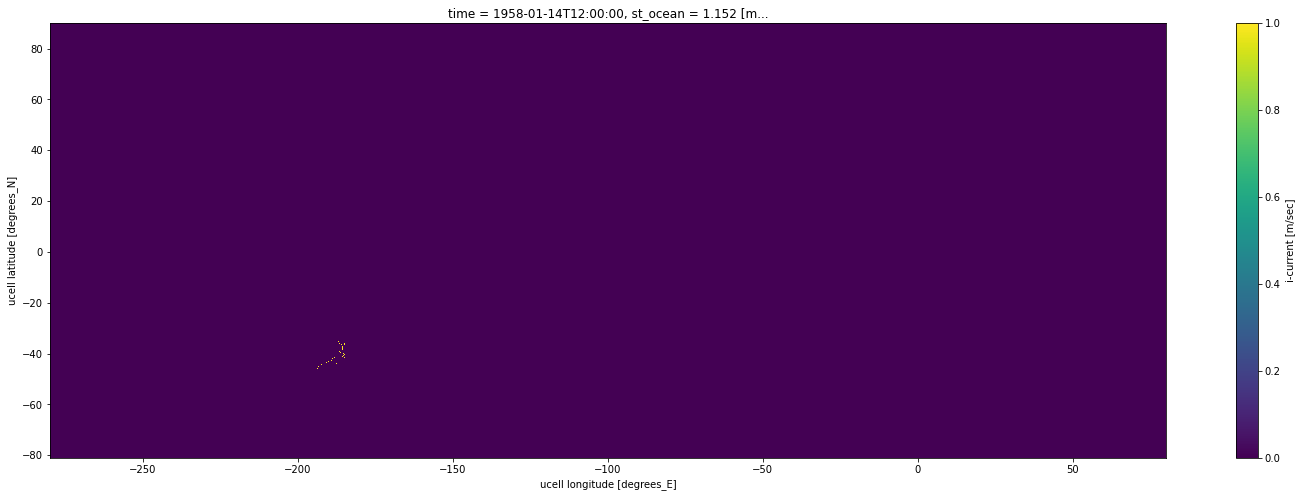

<Figure size 432x288 with 0 Axes>

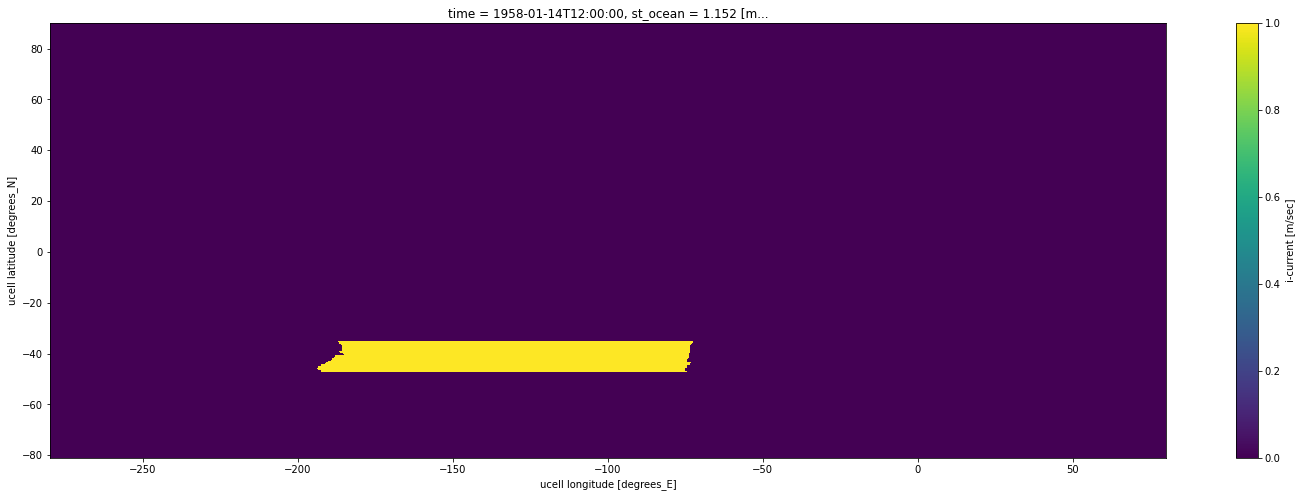

<Figure size 432x288 with 0 Axes>

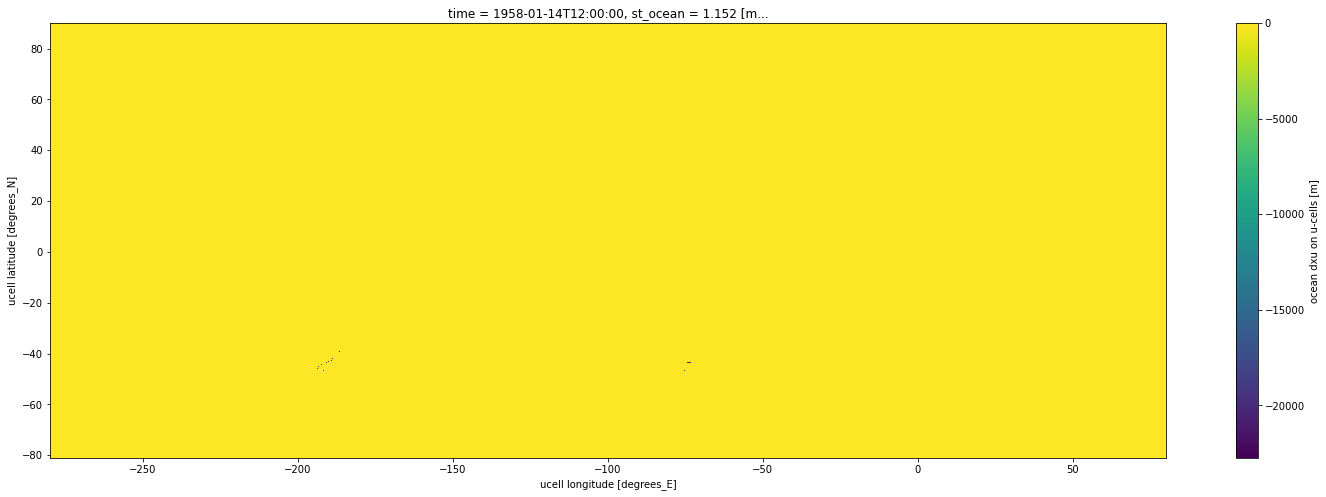

<Figure size 432x288 with 0 Axes>

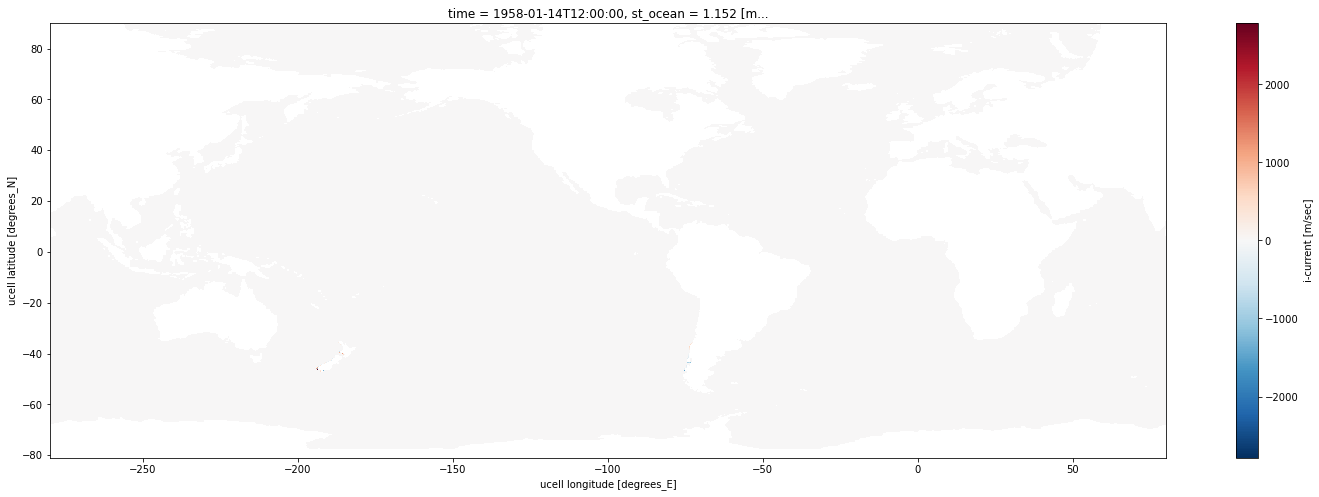

<Figure size 432x288 with 0 Axes>

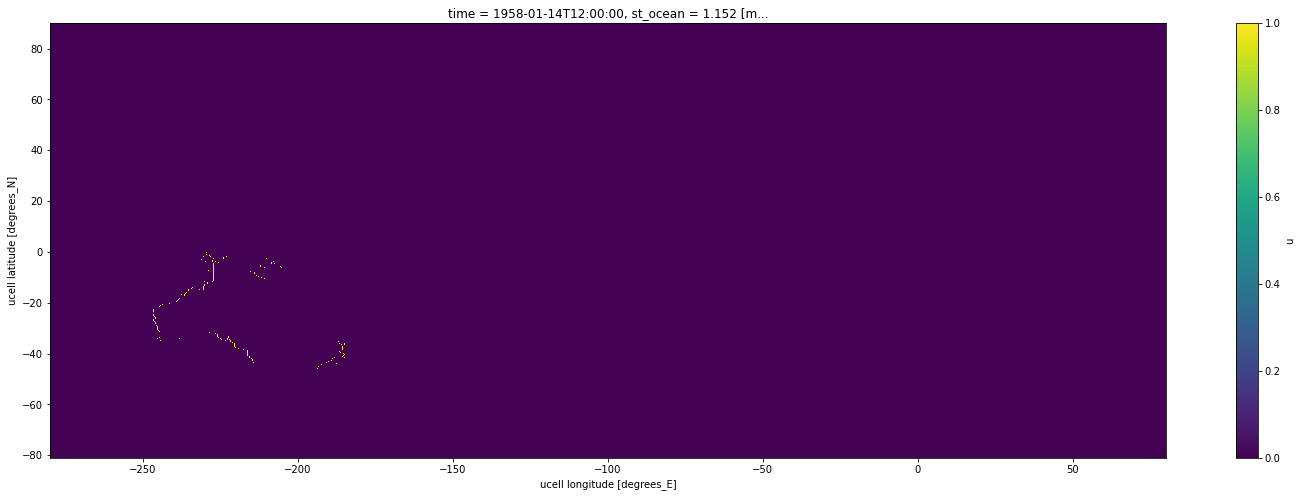

<Figure size 432x288 with 0 Axes>

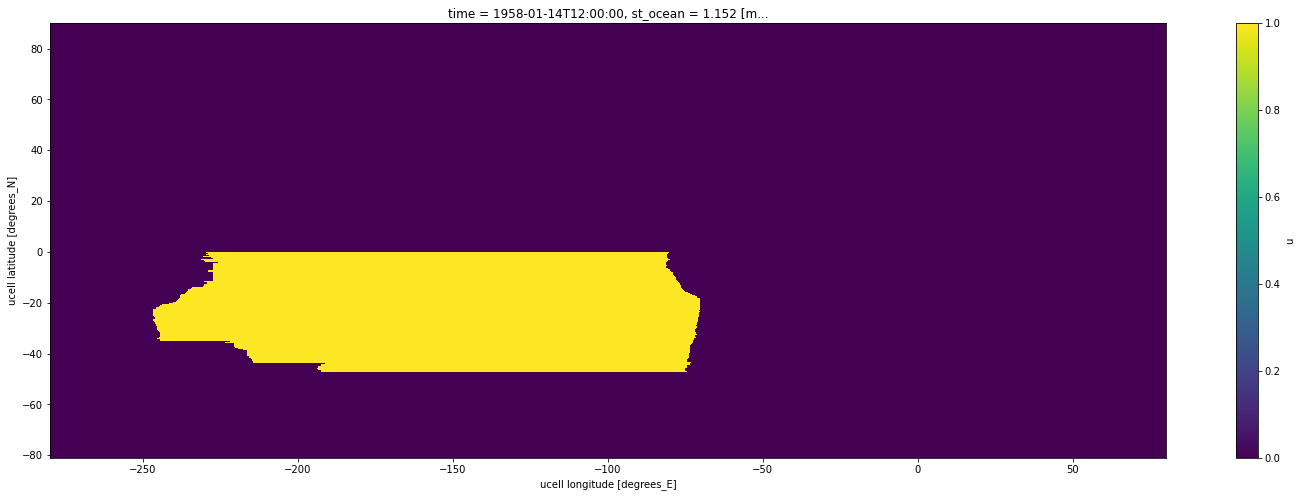

<Figure size 432x288 with 0 Axes>

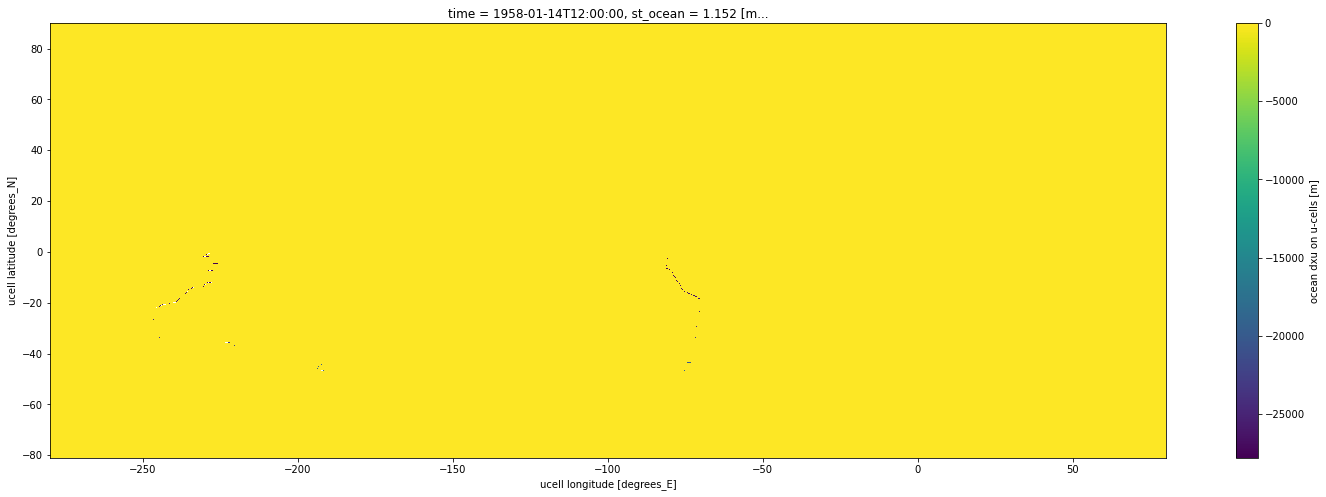

<Figure size 432x288 with 0 Axes>

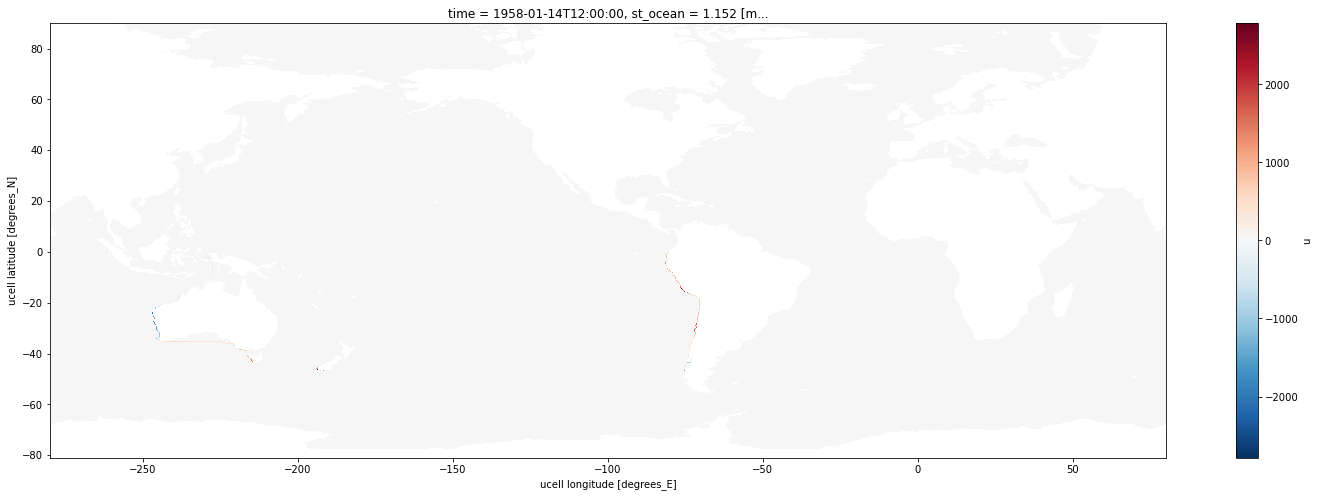

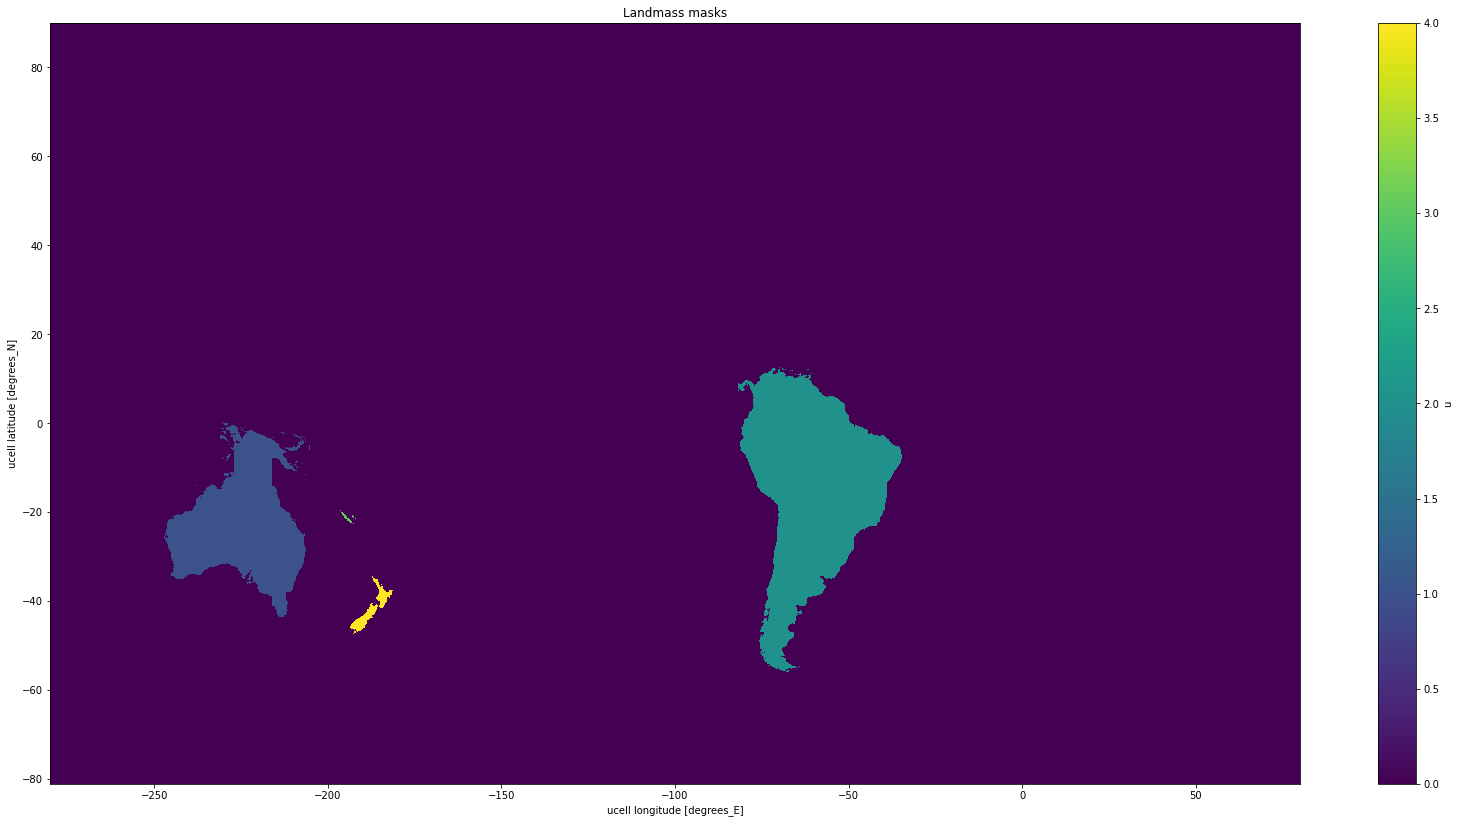

<Figure size 432x288 with 0 Axes>

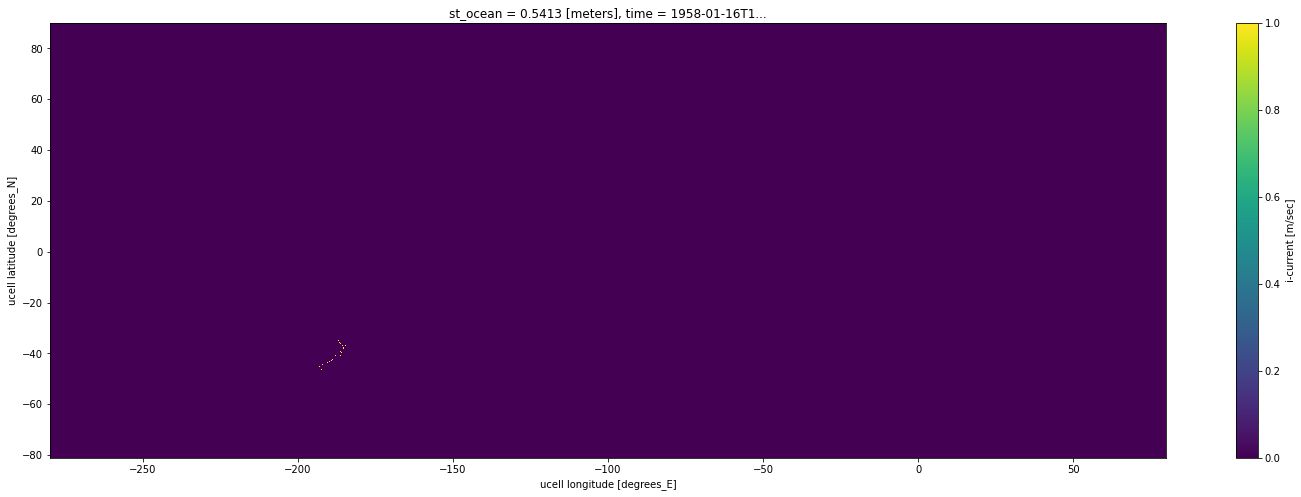

<Figure size 432x288 with 0 Axes>

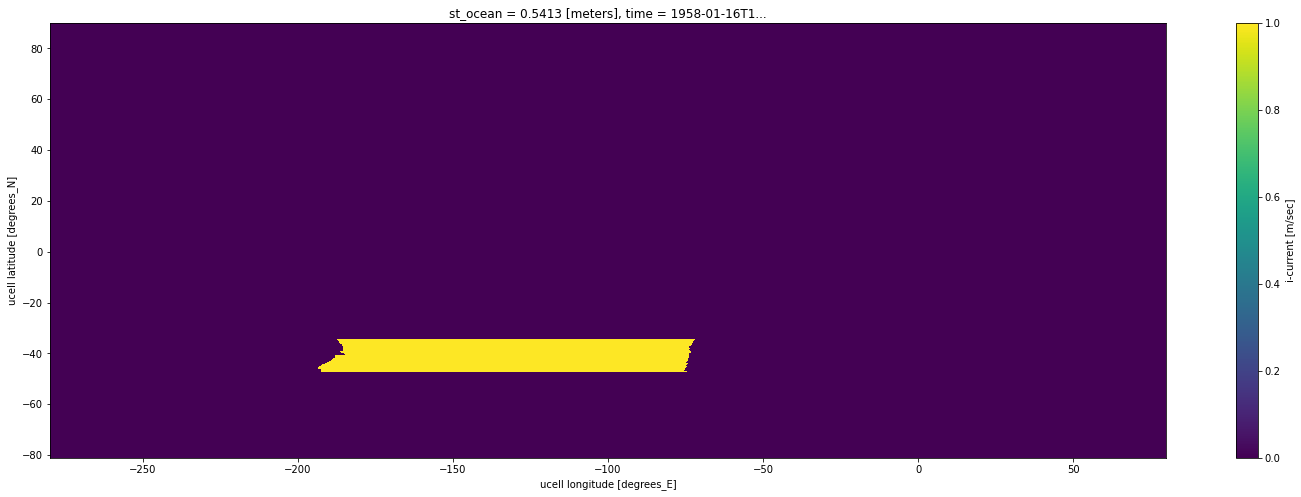

<Figure size 432x288 with 0 Axes>

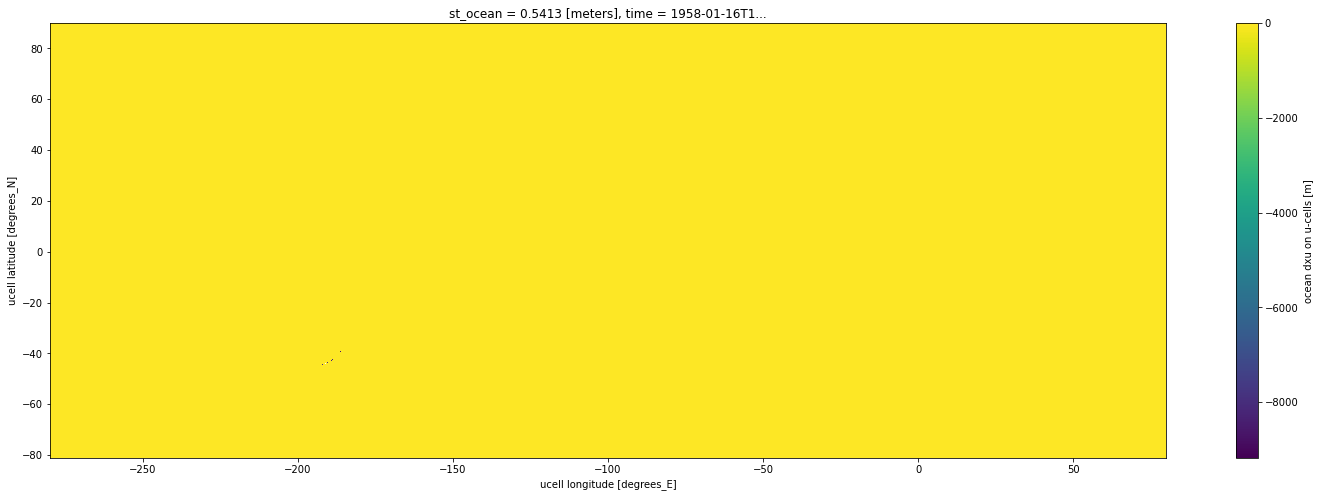

<Figure size 432x288 with 0 Axes>

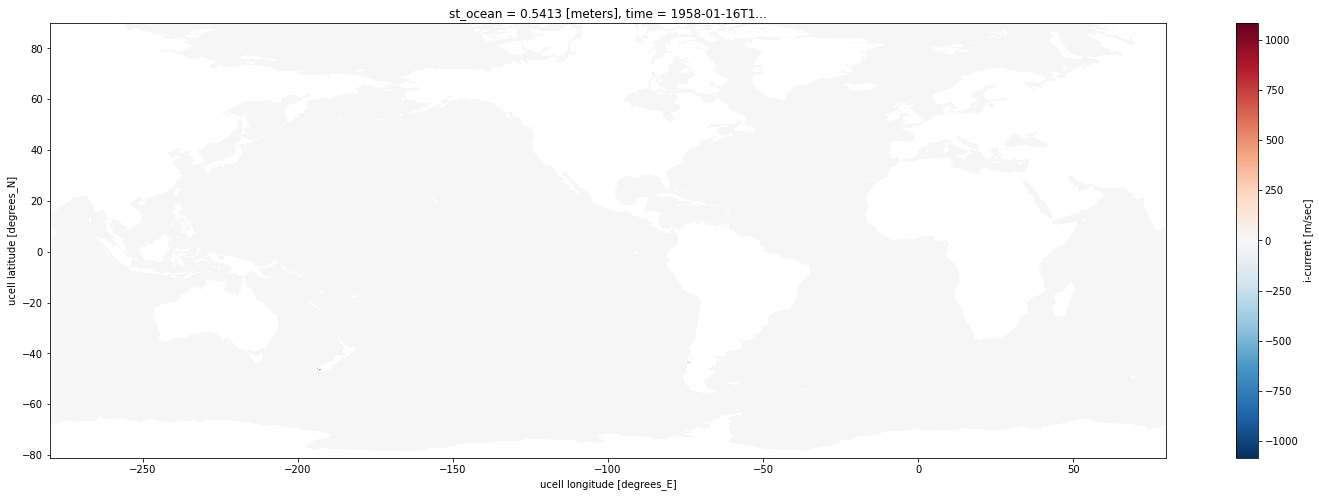

<Figure size 432x288 with 0 Axes>

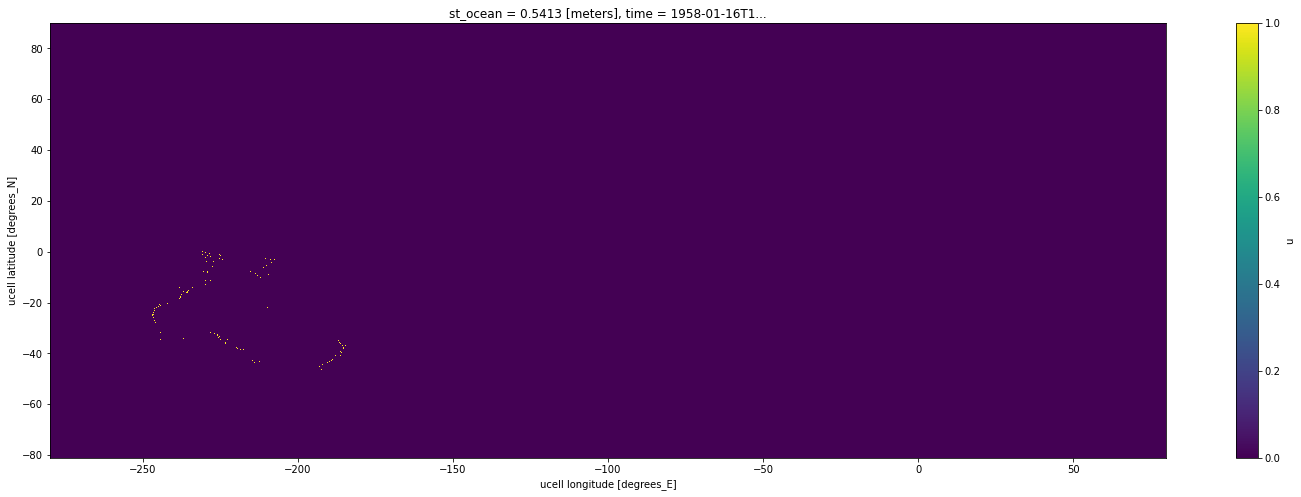

<Figure size 432x288 with 0 Axes>

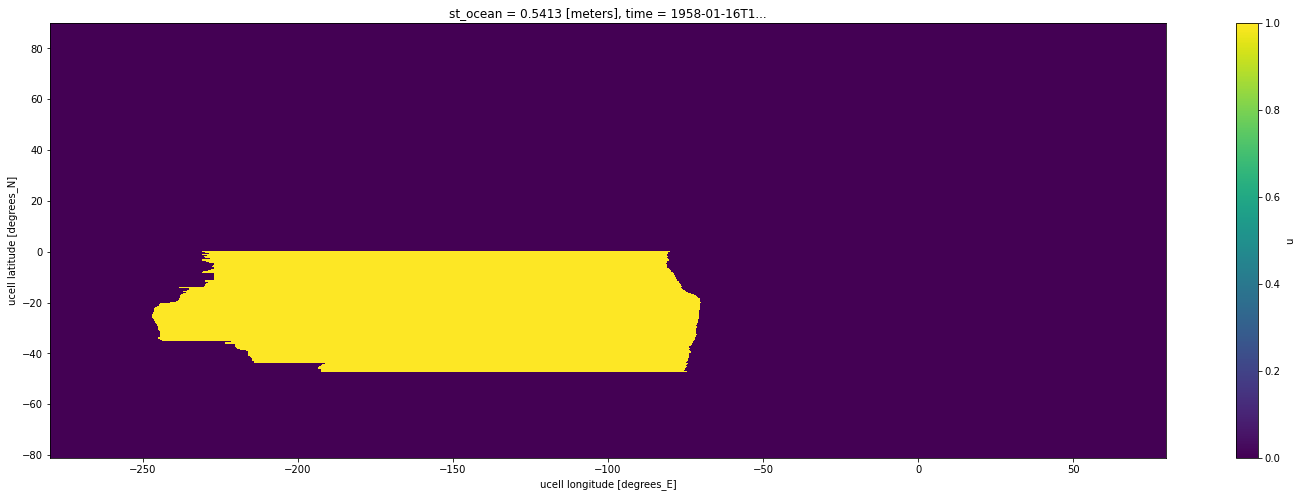

<Figure size 432x288 with 0 Axes>

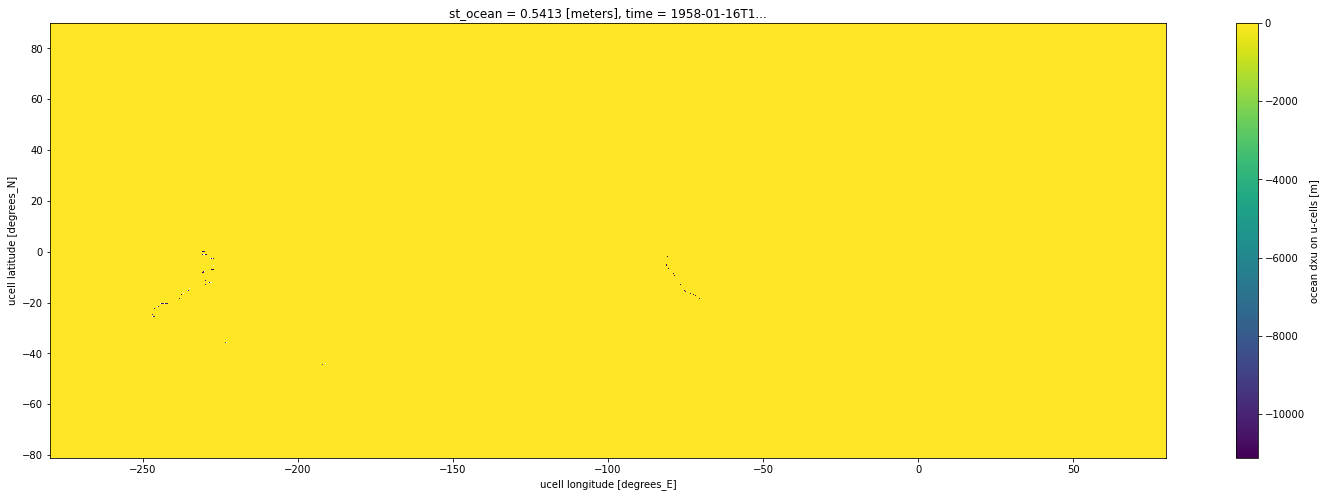

<Figure size 432x288 with 0 Axes>

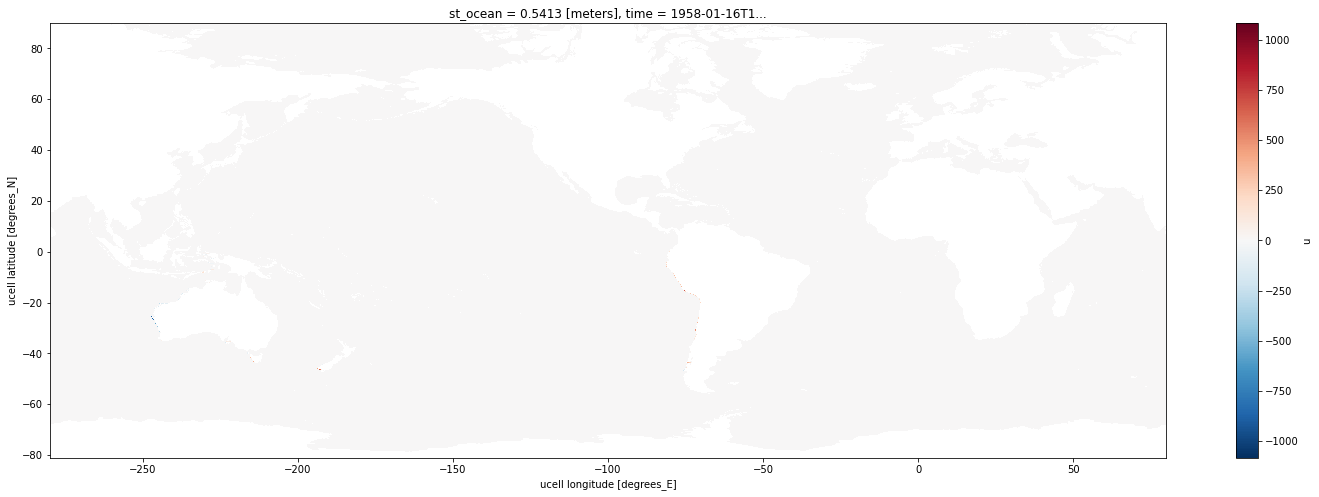

In [11]:
%%time

a1 = []
a2 = []

for ekey in data.keys():
    print(ekey)
    
    # devide time interval
    b1 = []
    b2 = []
    c = []
    for t in range (58,59,1):
        tstart = pd.to_datetime('1900/01/01') + pd.DateOffset(years=t)
        tend   = tstart + pd.DateOffset(years=1)
        
        c.append(str(tstart.year) +'-'+str(tend.year))
        print(str(tstart) +'-'+str(tend)) 
        
        # load data for each time interval
        expt = data[ekey]['expt']
        
        tau_x = cc.querying.getvar(expt, variable='tau_x', 
                                  session=session, frequency='1 monthly',
                                  start_time=str(tstart.year), 
                                  end_time=str(tend.year)).sel(time=slice(tstart,tend)).mean('time').compute()
        tau_y = cc.querying.getvar(expt, variable='tau_y', 
                                  session=session, frequency='1 monthly',
                                  start_time=str(tstart.year), 
                                  end_time=str(tend.year)).sel(time=slice(tstart,tend)).mean('time').compute()


        u = cc.querying.getvar(expt,'u',session,
                               frequency = '1 monthly',
                               start_time='1958-01-01 00:00:00', 
                               end_time='1958-03-01 00:00:00').isel(time=0).sel(st_ocean=0,method='nearest')

        dxu = cc.querying.getvar(expt, variable='dxu', 
                                 session=session, frequency='static', n=1)
        dyu = cc.querying.getvar(expt, variable='dyu', 
                                 session=session, frequency='static', n=1)
        
        # land mask
        lons = u.xu_ocean
        lats = u.yu_ocean

        Aus1 = np.isnan(u).where(lons>=-248,other=False).where(lons<=-205,other=False).where(lats>=-45,other=False).where(lats<=3.5,other=False)
        Aus2 = Aus1.where(lons<=-231,other=False).where(lats>=-13,other=False)
        Aus3 = Aus1 & (~Aus2)    
        Aus4 = Aus3.where(lons>=-216,True).where(lons<=-212,True).where(lats>=-41,True).where(lats<=-38,True)
        Aus5 = Aus3 | ~Aus4
        Aus6 = Aus5.where(lons>=-227,True).where(lons<=-216,True).where(lats>=-20,True).where(lats<=-4.3,True)
        Aus = Aus5 | (~Aus6)
        # TODO: join Australia and New Guinea, ie close Torres Strait? or at least check to see what difference this makes

        SAmer1 = np.isnan(u).where(lons>=-82,other=False).where(lons<=-34,other=False).where(lats>=-56,other=False).where(lats<=13,other=False)
        SAmer2 = SAmer1.where(lons>=-62,other=False).where(lats<=-49,other=False)
        SAmer = SAmer1 & (~SAmer2)
        # TODO: maybe remove Falkland island? but only if it causes problems

        NCal = np.isnan(u).where(lons>=-197,other=False).where(lons<=-191.5,other=False).where(lats>=-23,other=False).where(lats<=-19,other=False)
        NZ = np.isnan(u).where(lons>=-196,other=False).where(lons<=-180,other=False).where(lats>=-49,other=False).where(lats<=-33,other=False)

        # plot landmass masks
        fig, ax = plt.subplots(figsize=(28,14))

        (Aus + 2*SAmer + 3*NCal + 4*NZ).plot.pcolormesh(x='xu_ocean',y='yu_ocean')

        ax.set_title('Landmass masks')    

        islands=[NZ, Aus | NZ]
        
        # Island Rule
        IR1, IR2 = Island_Rule(dxu,dyu,tau_x,tau_y)
        
        b1.append(IR1)
        b2.append(IR2)

    a1.append(b1)
    a2.append(b2)

    
# test=pd.DataFrame({'1deg_c1':a1[0],'025deg_c1':a1[1],'01deg_c1':a1[2],
#                    '1deg_c2':a1[3],'025deg_c2':a1[4],'01deg_c2':a1[5],
#                    '1deg_c3':a1[6],'025deg_c3':a1[7],'01deg_c3':a1[8]})

# test.index = c
# print(test)
# round(test,2).to_csv('IR_NZ(1).csv')



# test=pd.DataFrame({'1deg_c1':a2[0],'025deg_c1':a2[1],'01deg_c1':a2[2],
#                    '1deg_c2':a2[3],'025deg_c2':a2[4],'01deg_c2':a2[5],
#                    '1deg_c3':a2[6],'025deg_c3':a2[7],'01deg_c3':a2[8]})

# test.index = c
# print(test)
# round(test,2).to_csv('IR_Aus(1).csv')

# # round(test,2).to_csv('IR_Aus-NZ(1).csv')

## standard deviation of Island Rule 